In [41]:
'''
Authors: Daniel M. Low
License: Apache 2.0

'''

import os
import re
import sys
import numpy as np
import pandas as pd
import json
from collections import Counter
from pprint import pprint
import requests
import time
from datetime import datetime, date, timedelta
import string
from scipy import stats
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import plotly.express as px
from plotly import graph_objs as go
from sklearn import preprocessing
from statsmodels.stats.multitest import multipletests
from scipy.interpolate import make_interp_spline, BSpline
import math

In [2]:
# # Run this cell to be able to mount GDrive and attach it to the colab so that we can save json outputs
# from google.colab import drive
# drive.mount('/content/drive')
# input_dir = './drive/My Drive/ML4HC_Final_Project/data/input/'
# output_dir = './drive/My Drive/ML4HC_Final_Project/data/output/'
input_dir = './../../datum/reddit/input/'
output_dir = './../../datum/reddit/output/'

import plotly.express as px
import plotly.graph_objs as go
import chart_studio.plotly as py

In [3]:
def histogram(y):
    sns.set(style='white', rc={'figure.figsize':(10,8)}, palette = "coolwarm", font_scale =1)
    labels, values = zip(*Counter(y).items())
    labels, values  = zip(*sorted(zip(labels, values )))
    labels = [int(n) for n in labels]


    indexes = np.arange(len(labels))
    width = 1

    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels, rotation=90)
    plt.show()
    return


In [4]:
# input y variable across time


def plot_across_time(subreddits, x = None, y_col = '', y_col_div_by = '', zscore=False, ylabel='Average negative sentiments',filter_small = True, small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.3, plot_covid_curves = False):
    '''
    y_col: {'all_words', ''}
    y_col_div_by: {'total_posts'}
    small_vale = if you want to include small posts, set to 0. 150 shizophrenia
    '''
    sns.set(style='white', rc={'figure.figsize':(10,8)}, font_scale =1.5)
    cmap = cm.Set3 # tab20c Set3
    cmap = cm.jet(np.linspace(0,1,len(subreddits)+1))
        
    # Load each rubreddit 
    for i,subreddit in enumerate(subreddits):

        df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
        # Some just have avg 10 posts per time segment, so not worth plotting        
        total_posts = df_subreddit[['subreddit', 'date']].groupby(['date']).agg(['count']).values
        if np.mean(total_posts)  < small_value:
            continue
        # Load y
        if y_col == 'total_posts':
            y = total_posts.copy()
        else:
            y = df_subreddit[[y_col, 'date']].groupby(['date']).agg(['sum']).values
        if y_col_div_by == 'total_posts':
            y = y/total_posts
        
        y = [n[0] for n in y]
        if zscore:
            if len(np.unique(y)) == 1:
                # By mistake I downloaded every 3 days and some subreddits max at 1000, so zscore of same values (1000,1000,..., 1000) is not possible                 
                continue
            else:
                y = stats.zscore(y)

        # Load x, is the same for all         
        if x == None:
            x = list(set(df_subreddit['date'].values))
            try: x.remove(np.nan)
            except: pass
            x.sort()
        x_num =range(len(x))  
        if plot_raw:
            plt.plot(x,y, alpha=alpha,color=cmap[i])
        if plot_line:
            m, b = np.polyfit(x_num, y, 1)
            plt.plot(x, m*x_num + b, color=cmap[i], alpha=1,label='r/'+subreddit)
        else:
            plt.plot(x,y, alpha=1,color=cmap[i],label='r/'+subreddit)
    
    plt.xticks(ticks=range(len(list(x))), labels=list(x),rotation=90)
    
    # Plot covid confirmed cases 
    if plot_covid_curves:
        for y_country, country,color in zip(y_countries, countries, ['k','gray','darkgray']):
            plt.plot(x,y_country, alpha=1,color=color, label='Confirmed cases - {}'.format(country))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if zscore:
        ylabel += ' (z-score)'
    plt.ylabel(ylabel)
    return



    

In [5]:

def boxplot_across_time(subreddit, x = None, y_col = '', y_col_div_by = '', zscore=False, ylabel='Average negative sentiments',filter_small = True, small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.3, plot_covid_curves = False):
    '''
    y_col: {'all_words', ''}
    y_col_div_by: {'total_posts'}
    small_vale = if you want to include small posts, set to 0. 150 shizophrenia
    '''
    sns.set(style='white', rc={'figure.figsize':(10,8)}, font_scale =1.5)
    cmap = cm.Set3 # tab20c Set3
    cmap = cm.jet(np.linspace(0,1,len(subreddits)+1))
        
    # Load each rubreddit 
    for i,subreddit in enumerate(subreddits):

        df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
        # Some just have avg 10 posts per time segment, so not worth plotting        
        total_posts = df_subreddit[['subreddit', 'date']].groupby(['date']).agg(['count']).values
        if np.mean(total_posts)  < small_value:
            continue
        # Load y
        y = df_subreddit[[y_col, 'date']].groupby(['date']).agg(['sum']).values
        if y_col_div_by == 'total_posts':
            y = y/total_posts
        
        y = [n[0] for n in y]
        if zscore:
            if len(np.unique(y)) == 1:
                # By mistake I downloaded every 3 days and some subreddits max at 1000, so zscore of same values (1000,1000,..., 1000) is not possible                 
                continue
            else:
                y = stats.zscore(y)

        # Load x, is the same for all         
        if x == None:
            x = list(set(df_subreddit['date'].values))
        x_num =range(len(x))  
        if plot_raw:
            plt.plot(x,y, alpha=alpha,color=cmap[i])
        if plot_line:
            m, b = np.polyfit(x_num, y, 1)
            plt.plot(x, m*x_num + b, color=cmap[i], alpha=1,label='r/'+subreddit)
        else:
            plt.plot(x,y, alpha=1,color=cmap[i],label='r/'+subreddit)
    
    plt.xticks(ticks=range(len(list(x))), labels=list(x),rotation=90)
    
    # Plot covid confirmed cases 
    if plot_covid_curves:
        for y_country, country,color in zip(y_countries, countries, ['k','gray','darkgray']):
            plt.plot(x,y_country, alpha=1,color=color, label='Confirmed cases - {}'.format(country))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if zscore:
        ylabel += ' (z-score)'
    plt.ylabel(ylabel)
    return



    

In [74]:
def timeseries_summary(input_dir, subreddit = 'personalfinance', pre_or_post = 'post', 
                       timestep = 2, metric='mean',weigh_by_Nwords = True,filter_days = False, apply_zscore=True, zscore_slope = True):
    # Merge different types of features     
    df = pd.read_csv(input_dir+'feature_extraction/new/covid19_counts/{}_{}_features_covid19_counts.csv'.format(subreddit,pre_or_post), index_col=0)
    features = list(df.columns)
    features = [n for n in features if n not in ['subreddit','author','date','post']]
    
    # Weigh value by amount of words in posts (if not amount of words will confound patterns in other variables)     
    if weigh_by_Nwords:
        # weight these variables by n_words
        weigh = features.copy()
        [weigh.remove(n) for n in ['n_chars', 'n_sents', 'n_words','sent_neg', 'sent_neu', 'sent_pos','sent_compound', 'automated_readability_index', 'coleman_liau_index',
               'flesch_kincaid_grade_level', 'flesch_reading_ease', 'gulpease_index',
               'lix', 'wiener_sachtextformel', 'gunning_fog_index', 'smog_index']]
        df[weigh] = df[weigh].div(df['n_words'].values, axis=0)

    
    # Group value by timestep     
    days = np.unique(df.date)
    if filter_days:
        for day in filter_days:
            days = [n for n in days if day not in n]
    days_timestep = days[::timestep]
    X = []
    y = []
    for i in range(0,len(days),timestep):
      days_week = days[i:i+timestep]
      df_week = df[df.date.isin(days_week)]
      df_week_feature_cols = df_week[features].values
      df_week_y = list(df_week.subreddit)
      X.append(df_week_feature_cols)
      y.append(df_week_y)

    X = np.array(X)
    y = np.array(y)
    
    # Take summary stat metric by timestep     
    summary = []
    for timestep in X:
        n_posts = timestep.shape[0] 
        if metric == 'mean':
            # sum will depend on subreddit size, so can only be used if subreddits are balanced.              
            summary_timestep = list(timestep.mean(axis=0))

        timestep_df = pd.DataFrame(timestep, columns=features)
        summary_timestep.append(n_posts)
        summary.append(summary_timestep)

    summary = pd.DataFrame(summary)
    
    if apply_zscore:
        summary = summary.apply(zscore)
    summary = summary.T
    summary.columns = days_timestep
    summary.index = features+['n_posts']

    # add slope and p-value
    slopes = []
    p_values = []
    significances = []
    r2 = []
    for feature in features+['n_posts']:
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(len(summary.T.index)), summary.T[feature])
        slopes.append(slope)
        p_values.append(p_value)
        r2.append(r_value**2)
        alpha = 0.05     # corrected_alpha = 0.05/len(features)
        if p_value <= alpha:
            significances.append(1)
        else:
            significances.append(-1)
    
    if zscore_slope:
        summary['slope'] = stats.zscore(slopes)
        summary['p_value'] = stats.zscore(p_values)
        summary['sign'] = stats.zscore(significances)
        summary['r2'] = stats.zscore(r2)
    else:
        summary['slope'] = slopes
        summary['p_value'] = p_values
        summary['sign'] = significances
        summary['r2'] = r2
        
    return summary
    

## Load subreddits and order them 

In [8]:
#     reorder by related subreddits
subreddits = [
     'COVID19_support',
'mentalhealth',
    'anxiety',
     'socialanxiety',
     'healthanxiety',
         'autism',
 'adhd',  
     'ptsd',
     'lonely',
     'depression',
 'suicidewatch',    
     'bipolarreddit',
     'bpd',
     'schizophrenia',
    'addiction',
     'alcoholism',
 'EDAnonymous',
 'personalfinance',
     'conspiracy',
     'guns',
 'legaladvice',    
    'divorce',
 'relationships',
    'parenting',
    'teaching',
 'meditation',
 'fitness',
 'jokes'
]

subreddits_mental_health = [
     'anxiety',
     'socialanxiety',
     'healthanxiety',
         'autism',
 'adhd',  
     'ptsd',
     'lonely',
     'depression',
 'suicidewatch',    
     'bipolarreddit',
     'bpd',
    'addiction',
     'alcoholism',
 'EDAnonymous',
 'schizophrenia']
    

In [10]:
# Filter features
keep = [
    'n_posts', 'n_words',     'n_chars', 'punctuation',  'n_sents', 
    #     word_type
    'n_unique_words', 'n_long_words',        'n_syllables',   'n_monosyllable_words', 'n_polysyllable_words', 
    
#     functionals    
    'liwc_total_functional', 'liwc_impersonal_pronouns', 'liwc_total_pronouns', 'liwc_personal_pronouns',
'liwc_1st_pers', 'liwc_2nd_pers', 'liwc_3rd_pers', 
       'liwc_articles_article', 
#     POS
    'liwc_common_verbs',
       'liwc_auxiliary_verbs', 'liwc_past_tense', 'liwc_present_tense', 'liwc_future_tense',
       'liwc_adverbs', 'liwc_prepositions', 'liwc_conjunctions', 'liwc_negations',    'liwc_assent',
       'liwc_quantifiers', 'liwc_numbers', 
    'liwc_nonfluencies', 'liwc_fillers',
    
#     readability
    'flesch_kincaid_grade_level', 'lix',
'automated_readability_index',
       'coleman_liau_index',
       'flesch_reading_ease', 'gulpease_index', 'gunning_fog_index',
       'smog_index', 'wiener_sachtextformel',     

#    Sentiment 
    'sent_neg', 'sent_neu', 'sent_pos',
       'sent_compound', 
    'liwc_affective_processes',
       'liwc_positive_emotion', 'liwc_negative_emotion', 'liwc_anxiety', 'liwc_anger','liwc_swear_words', 
       'liwc_sadness',
# Existential / death    
    'liwc_religion', 
    'liwc_death', 'guns_total','substance_use_total', 'suicidality_total',
# Cognitive    
    'liwc_cognitive', 'liwc_insight', 'liwc_causation', 'liwc_discrepancy',
       'liwc_tentative', 'liwc_certainty', 'liwc_inhibition', 'liwc_inclusive', 'liwc_exclusive',
       'liwc_perceptual_processes', 'liwc_see', 'liwc_hear', 'liwc_feel', 
# Biological
    'liwc_biological',
'liwc_ingestion', 'liwc_relativity', 'liwc_motion','liwc_body', 'liwc_health', 'liwc_sexual', 
    # Work, economic stress, leisure
    'liwc_work',     'liwc_leisure',  'economic_stress_total', 'liwc_money','liwc_time','liwc_achievement',
    # Social and home and isolation
    'liwc_social_processes','liwc_home',         
    'domestic_stress_total','liwc_space',    
       'liwc_family', 'liwc_friends', 'liwc_humans', 'isolation_total',
#     covid
        'covid19_total',  
    
]





## How many times is COVID19mentioned and when?


### Find covid19 related words

In [11]:
# # What are the top terms in COVID19_support 
# from sklearn.feature_extraction.text import TfidfVectorizer

# subreddit = 'COVID19_support'
# docs_covid = pd.read_csv(input_dir+'docs_covid19.csv', index_col=0)
# docs_rest = pd.read_csv(input_dir+'docs_pre_all_subreddits.csv',index_col=0)['docs_train'].values

# docs_covid = np.array([n for i in docs_covid.values for n in i])
# # docs_rest = np.array([n for i in docs_rest.values for n in i])




In [12]:
# Find top tfidf words for covid19_support: didn´t work as well as online glossary
# from nltk import PorterStemmer
# import re
# def stemming_tokenizer(str_input):

# 	'''
# 	http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/

# 	:param str_input:
# 	:return:
# 	'''
# 	porter_stemmer = PorterStemmer()
# 	words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
# 	words = [porter_stemmer.stem(word) for word in words]
# 	return words


# tfidf = TfidfVectorizer(tokenizer=stemming_tokenizer, ngram_range=(1,2), stop_words='english',max_features=512, min_df=2, max_df=0.8)
# tfidf.fit_transform(docs_rest)
# target = tfidf.transform(docs_covid)
# feature_array = np.array(tfidf.get_feature_names())
# tfidf_sorting = np.argsort(target.toarray()).flatten()[::-1]



In [13]:
# # List top terms for covid19
# n = 1000
# top_n = feature_array[tfidf_sorting][:n]
# print(top_n)

In [14]:
# from collections import Counter
# counter = Counter(docs_covid_str.split(' '))
# counter.most_common()

In [ ]:
# After not getting very informative results with tfidf I end up using this: https://www.tmc.edu/news/2020/05/covid-19-crisis-catalog-a-glossary-of-terms/
# Count number times a specific phrase appears in the text.
def count_words(doc,phrases=[]):
    # remove punctuation except apostrophes because we need to search for things like "don't want to live"
    text = re.sub("[^\w\d'\s]+",'',doc.lower())
    counter = 0
    for phrase in phrases:
        counter += text.count(phrase)
    return counter



# Words should not be frequent in mental health subreddits outside of pandemic. didnt include flu, because it's in "influence", etc.
words = ['corona','virus','viral','covid', 'sars','influenza','pandemic', 'epidemic', 
         'quarantine','lockdown', 'distancing', 'national emergency', 'flatten', 
             'infect','ventilator', 'mask','symptomatic',
            'epidemiolog', 'immun', 'incubation', 'transmission','vaccine', ]


pre_or_post = 'post'

for subreddit in subreddits:
    df = pd.read_csv(input_dir+'feature_extraction/new/tfidf_combined/{}_{}_features_tfidf_256.csv'.format(subreddit,pre_or_post))    
    posts = df.post.values
    counts_covid = [count_words(post,phrases=words) for post in posts]
    df_new = df[['subreddit','date', 'post', 'n_words']]
    df_new['covid19_boolean'] = [n/n if n>0 else n for n in counts_covid]
    df_new['covid19_total'] = counts_covid
    df_new['covid19_weighed_words'] = counts_covid
    df_new['covid19_weighed_words'] = df_new['covid19_weighed_words'].div(df_new['n_words'].values, axis=0)
    df_new.to_csv(input_dir+'feature_extraction/new/covid19_counts/{}_{}_features_covid19_counts.csv'.format(subreddit,pre_or_post))
    
    



In [88]:
# ERASE
files = os.listdir(input_dir+'final_features')
for file in files[10:]:
    print(file)
    df = pd.read_csv(input_dir+'final_features/'+file, index_col = 0)
    del df['covid19_total']
    df.to_csv(input_dir+'final_features/'+file)


CanadaPolitics_pre_features_tfidf_256.csv
socialanxiety_2019_features_tfidf_256.csv
lonely_2018_features_tfidf_256.csv
teaching_2019_features_tfidf_256.csv
mentalhealth_pre_features_tfidf_256.csv
unitedkingdom_2019_features_tfidf_256.csv
legaladvice_2018_features_tfidf_256.csv
CanadaPolitics_2018_features_tfidf_256.csv
ForeverAlone_2019_features_tfidf_256.csv
lonely_pre_features_tfidf_256.csv
alcoholism_pre_features_tfidf_256.csv
ukpolitics_pre_features_tfidf_256.csv
bipolarreddit_2019_features_tfidf_256.csv
meditation_2018_features_tfidf_256.csv
schizophrenia_2018_features_tfidf_256.csv
ptsd_pre_features_tfidf_256.csv
ForeverAlone_pre_features_tfidf_256.csv
jokes_2018_features_tfidf_256.csv
ForeverAlone_post_features_tfidf_256.csv
psychosis_2018_features_tfidf_256.csv
fitness_2018_features_tfidf_256.csv
bipolarreddit_post_features_tfidf_256.csv
depression_pre_features_tfidf_256.csv
psychosis_2019_features_tfidf_256.csv
fitness_2019_features_tfidf_256.csv
jokes_2019_features_tfidf_256.

In [35]:
summary =  timeseries_summary(input_dir, subreddit = 'addiction', pre_or_post = 'post', 
                           timestep = 2, metric='mean',weigh_by_Nwords = False,filter_days = False, apply_zscore=False, zscore_slope = False)
    
x_name = summary.columns[:-4].values
    
# Load confirmed COVID19 cases from Our World in Data dataset
total_cases = pd.read_csv(input_dir+'total_cases.csv')
# Select only these days
days = [n.replace('/', '-') for n in x_name]
total_cases = total_cases[total_cases.date.isin(days)]
usa = total_cases['United States'].values
world = total_cases['World'].values
china = total_cases['China'].values

In [36]:
usa = [int(str(n).replace('0','1')) for n in usa]
china = [int(str(n).replace('0','1')) for n in china]

In [66]:
subreddits_mental_health_sorted = subreddits_mental_health.copy()
subreddits_mental_health_sorted.sort()
subreddits_mental_health_sorted.remove('EDAnonymous') #so the colors are better distributed
subreddits_mental_health_sorted.insert(8, 'EDAnonymous')
subreddits_mental_health_sorted.remove('alcoholism') #so the colors are better distributed
subreddits_mental_health_sorted.insert(0, 'alcoholism')
subreddits_mental_health_sorted.remove('anxiety') #so the colors are better distributed
subreddits_mental_health_sorted.insert(2, 'anxiety')
subreddits_mental_health_sorted

['alcoholism',
 'addiction',
 'anxiety',
 'adhd',
 'autism',
 'bipolarreddit',
 'bpd',
 'depression',
 'EDAnonymous',
 'healthanxiety',
 'lonely',
 'ptsd',
 'schizophrenia',
 'socialanxiety',
 'suicidewatch']

alcoholism
=====covid19_boolean====
addiction
=====covid19_boolean====
anxiety
=====covid19_boolean====
adhd
=====covid19_boolean====
autism
=====covid19_boolean====
bipolarreddit
=====covid19_boolean====
bpd
=====covid19_boolean====
depression
=====covid19_boolean====
EDAnonymous
=====covid19_boolean====
healthanxiety
=====covid19_boolean====
lonely
=====covid19_boolean====
ptsd
=====covid19_boolean====
schizophrenia
=====covid19_boolean====
socialanxiety
=====covid19_boolean====
suicidewatch
=====covid19_boolean====


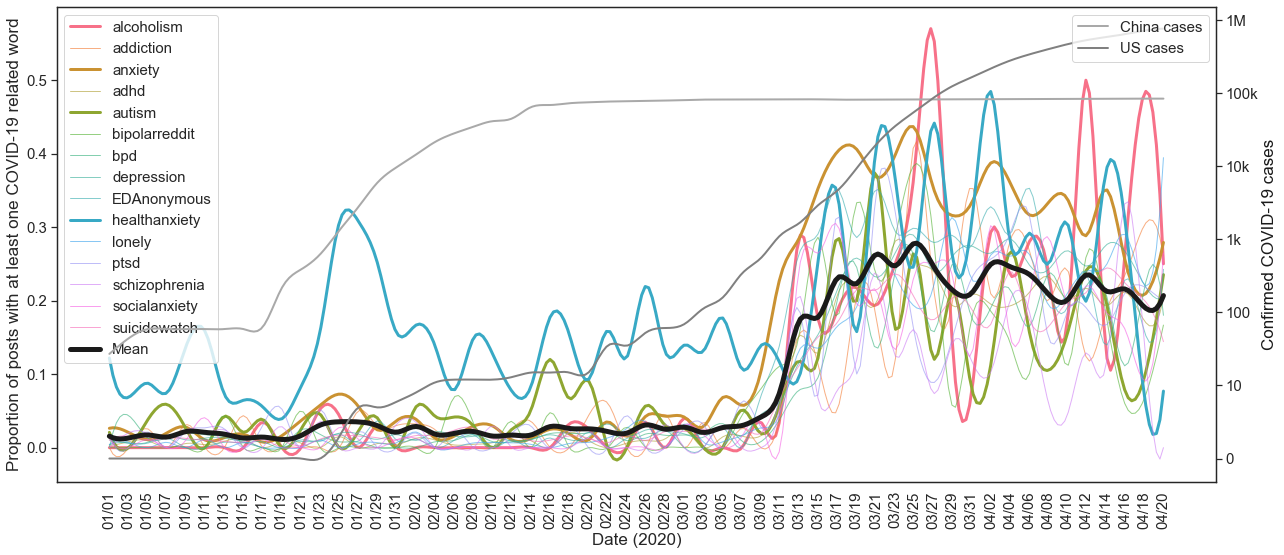

alcoholism
=====covid19_weighed_words====
addiction
=====covid19_weighed_words====
anxiety
=====covid19_weighed_words====
adhd
=====covid19_weighed_words====
autism
=====covid19_weighed_words====
bipolarreddit
=====covid19_weighed_words====
bpd
=====covid19_weighed_words====
depression
=====covid19_weighed_words====
EDAnonymous
=====covid19_weighed_words====
healthanxiety
=====covid19_weighed_words====
lonely
=====covid19_weighed_words====
ptsd
=====covid19_weighed_words====
schizophrenia
=====covid19_weighed_words====
socialanxiety
=====covid19_weighed_words====
suicidewatch
=====covid19_weighed_words====


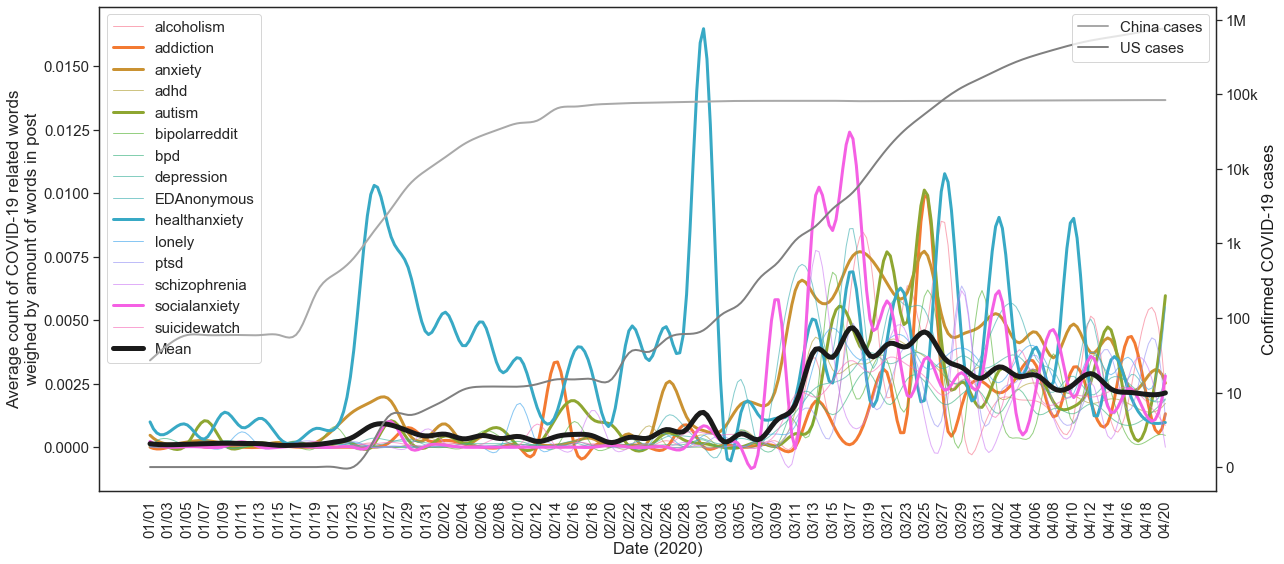

In [75]:


# y, x for each subreddit
for variable in ['covid19_boolean','covid19_weighed_words']:
    covid_mentions = []
    for sr in subreddits_mental_health_sorted:
        print(sr)
        summary =  timeseries_summary(input_dir, subreddit = sr, pre_or_post = 'post', 
                           timestep = 2, metric='mean',weigh_by_Nwords = False,filter_days = False, apply_zscore=False, zscore_slope = False)
        sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)
        # for variable in keep:

        print('====={}===='.format(variable))
        x_name = summary.columns[:-4].values
        x_name = [n.replace('2020/','') for n in x_name]
        x = range(len(x_name))
        y = summary.T[variable][:-4].values
        covid_mentions.append([sr, y, x_name, x])



    # Mean across subreddits
    covid_mean = [n[1] for n in covid_mentions]
    covid_mean = np.mean(covid_mean, axis=0)



    if variable == 'covid19_boolean':
        log_base = 10
        scale_covid_cases = 1
        ylabel_name = f'Proportion of posts with at least one COVID-19 related word'
        subreddits_highlight = ['healthanxiety', 'alcoholism', 'anxiety', 'autism']
    elif variable == 'covid19_total':
        log_base = 10
        scale_covid_cases = 1
        ylabel_name = f'Average count of COVID-19 related words'
        subreddits_highlight = ['healthanxiety', 'anxiety', 'autism', 'ptsd']
    elif variable == 'covid19_weighed_words':
        log_base = 10
        scale_covid_cases = 1
        ylabel_name = f'Average count of COVID-19 related words\nweighed by amount of words in post'
        subreddits_highlight = ['healthanxiety', 'anxiety', 'autism', 'socialanxiety','addiction']
    
    china_log = np.array([math.log(n, log_base) for n in china])
    usa_log = np.array([math.log(n, log_base) for n in usa])

    #   Plot
    sns.set(style='white', rc={'figure.figsize':(18,8)}, font_scale =1, palette=sns.color_palette("husl", 15))
    fig, ax1 = plt.subplots()

    for sr, y, x_name, x in covid_mentions:
        x = list(x)
        xnew = np.linspace(np.min(x), np.max(x), 300)  
        spl = make_interp_spline(x, y, k=3)  # type: BSpline
        power_smooth = spl(xnew)
        alpha=0.6
        linewidth = 1
        if sr in subreddits_highlight:
            alpha=1
            linewidth = 3
        ax1.plot(xnew,power_smooth, label=sr, alpha=alpha, linewidth=linewidth)

    # # Plot Mean
    spl = make_interp_spline(x, covid_mean, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    ax1.plot(xnew,power_smooth, label='Mean', alpha=1, linewidth=5.0, c = 'k')

    # Confirmed cases
    # China
    ax2 = ax1.twinx() # create second y axis
    spl = make_interp_spline(x, china_log, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    ax2.plot(xnew,power_smooth/scale_covid_cases, label='China cases', alpha=1, linewidth=2.0, c='darkgray')
    # usa
    spl = make_interp_spline(x, usa_log, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    ax2.plot(xnew,power_smooth/scale_covid_cases, label='US cases', alpha=1, linewidth=2.0, c='gray')

    # Plot the rest
    ax1.legend(loc='upper left',prop={'size': 15})
    ax2.legend(loc='upper right',prop={'size': 15})
    ax1.set_ylabel(ylabel_name, fontsize=17)
    ax1.set_xlabel('Date (2020)', fontsize=17)
    ax1.set_xticks(ticks=x)
    ax1.set_xticklabels(x_name, rotation=90, fontsize=15)
    ax1.tick_params(axis='y', which='major', labelsize=15)
    limits_ax2 = ['0', '10','100','1k','10k','100k','1M']
    yticks_ax2 = np.arange(0,len(limits_ax2))
    ax2.set_yticks(ticks=yticks_ax2)
    ax2.set_yticklabels(limits_ax2, fontsize=15)
    ax2.set_ylabel(f'Confirmed COVID-19 cases', color='k', fontsize=17)
    plt.tight_layout()

    plt.savefig(output_dir+f'covid_{variable}.png', dpi=400)
    plt.show()

In [ ]:


#   Plot
sns.set(style='white', rc={'figure.figsize':(18,8)}, font_scale =1, palette=sns.color_palette("husl", 15))
fig, ax1 = plt.subplots()



for sr, y, x_name, x in covid_mentions:
    x = list(x)
    xnew = np.linspace(np.min(x), np.max(x), 300)  
    spl = make_interp_spline(x, y, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    alpha=0.6
    linewidth = 1
    if sr in subreddits_highlight:
        alpha=1
        linewidth = 2
    ax1.plot(xnew,power_smooth, label=sr, alpha=alpha, linewidth=linewidth)

# # Plot Mean
spl = make_interp_spline(x, covid_mean, k=3)  # type: BSpline
power_smooth = spl(xnew)
ax1.plot(xnew,power_smooth, label='Mean', alpha=1, linewidth=5.0, c = 'r')

# Confirmed cases
# China
ax2 = ax1.twinx() # create second y axis
spl = make_interp_spline(x, china_log, k=3)  # type: BSpline
power_smooth = spl(xnew)
ax2.plot(xnew,power_smooth/scale_covid_cases, label='China cases', alpha=1, linewidth=2.0, c='darkgray')
# usa
spl = make_interp_spline(x, usa_log, k=3)  # type: BSpline
power_smooth = spl(xnew)
ax2.plot(xnew,power_smooth/scale_covid_cases, label='US cases', alpha=1, linewidth=2.0, c='gray')

# Plot the rest
ax1.legend(loc='upper left',prop={'size': 15})
ax2.legend(loc='upper right',prop={'size': 15})
ax1.set_ylabel(ylabel_name, fontsize=15)
ax1.set_xlabel('Date (2020)', fontsize=15)
ax1.set_xticks(ticks=x)
ax1.set_xticklabels(x_name, rotation=90, fontsize=15)
ax1.tick_params(axis='y', which='major', labelsize=15)
limits_ax2 = ['0', '10','100','1k','10k','100k','1M']
yticks_ax2 = np.arange(0,len(limits_ax2))
ax2.set_yticks(ticks=yticks_ax2)
ax2.set_yticklabels(limits_ax2, fontsize=15)
ax2.set_ylabel(f'Confirmed COVID-19 cases', color='k', fontsize=15)
plt.tight_layout()

# plt.savefig(output_dir+f'covid_{variable}.png', dpi=400)
plt.show()



In [ ]:

china_log = np.array([math.log(n, 10) for n in china])
usa_log = np.array([math.log(n, 10) for n in usa])
scale_covid_cases =1


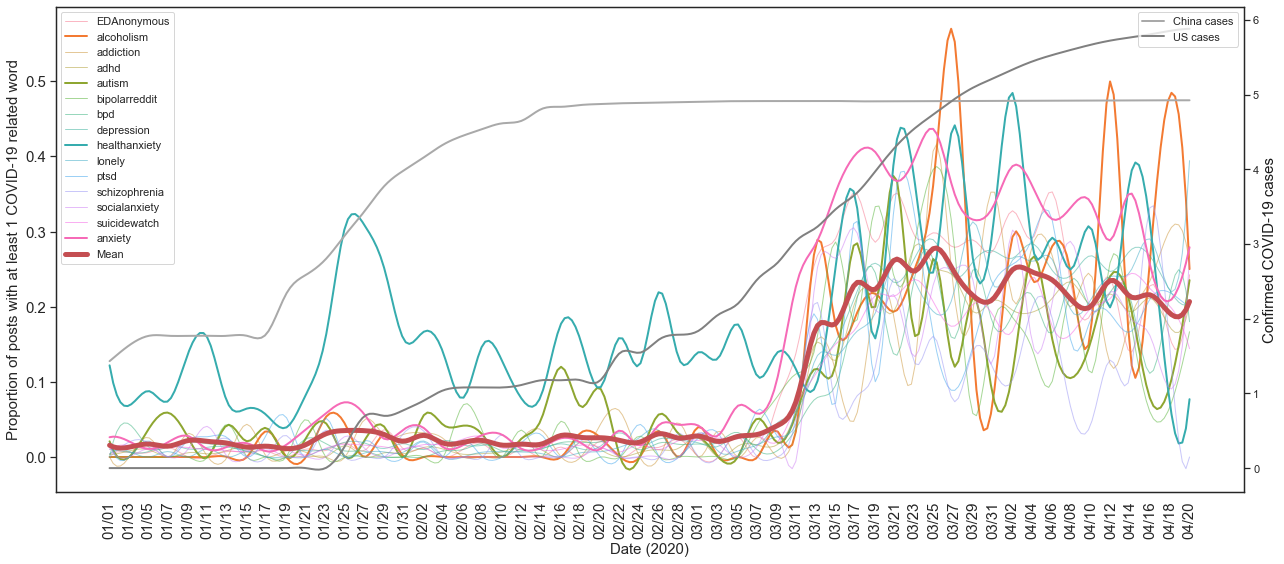

In [289]:

china_log = np.array([math.log(n, 10) for n in china])
usa_log = np.array([math.log(n, 10) for n in usa])
scale_covid_cases =1


#   Plot
sns.set(style='white', rc={'figure.figsize':(18,8)}, font_scale =1, palette=sns.color_palette("husl", 15))
fig, ax1 = plt.subplots()



for sr, y, x_name, x in covid_mentions:
    x = list(x)
    xnew = np.linspace(np.min(x), np.max(x), 300)  
    spl = make_interp_spline(x, y, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    alpha=0.5
    linewidth = 1
    if sr in subreddits_highlight:
        alpha=1
        linewidth = 2
    ax1.plot(xnew,power_smooth, label=sr, alpha=alpha, linewidth=linewidth)

# # Plot Mean
spl = make_interp_spline(x, covid_mean, k=3)  # type: BSpline
power_smooth = spl(xnew)
ax1.plot(xnew,power_smooth, label='Mean', alpha=1, linewidth=5.0, c = 'r')

# Confirmed cases
# China
ax2 = ax1.twinx() # create second y axis
spl = make_interp_spline(x, china_log, k=3)  # type: BSpline
power_smooth = spl(xnew)
ax2.plot(xnew,power_smooth/scale_covid_cases, label='China cases', alpha=1, linewidth=2.0, c='darkgray')
# usa
spl = make_interp_spline(x, usa_log, k=3)  # type: BSpline
power_smooth = spl(xnew)
ax2.plot(xnew,power_smooth/scale_covid_cases, label='US cases', alpha=1, linewidth=2.0, c='gray')

# Plot the rest
#     limits_ax1 = np.round(np.linspace(np.min(covid_mean),np.max(covid_mean),14),2)
limits_ax2 = list(range(0,50000,5000))
# limits_ax2 = [str(n).replace('0000','0k  ').replace('000', 'k  ') for n in limits_ax2]
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_ylabel(ylabel_name, fontsize=15)
ax1.set_xlabel('Date (2020)', fontsize=15)
ax1.set_xticks(ticks=x)
ax1.set_xticklabels(x_name, rotation=90, fontsize=15)
# ax1.set_yticklabels(limits_ax1, fontsize=15)
ax1.tick_params(axis='y', which='major', labelsize=15)

# ax2.set_yticklabels(limits_ax2, fontsize=15)

# ax2.set_ylabel(f'Confirmed COVID-19 cases (log x /{scale_covid_cases})', color='k', fontsize=15)
ax2.set_ylabel(f'Confirmed COVID-19 cases', color='k', fontsize=15)
plt.tight_layout()

# plt.savefig(output_dir+f'covid_{variable}_{metric}.png', dpi=400)
plt.show()


# Plot raw data for a single feature

r2: 0.00039896678560895403 p-value:  9.794376965594224e-05


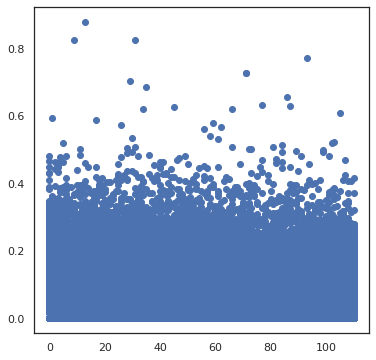

In [0]:
sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)

# Load a single subreddit
subreddit = 'depression'
df = pd.read_csv(input_dir+'feature_extraction/new/{}_{}_features.csv'.format(subreddit,pre_or_post))

feature='sent_pos'
x = df.date.values
le = preprocessing.LabelEncoder()
y = df[feature].values
x = le.fit_transform(x)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.scatter(x,y)
print('r2:',r_value**2, 'p-value: ',p_value)


r2: 0.18106204448434088 p-value:  3.230680442427489e-06


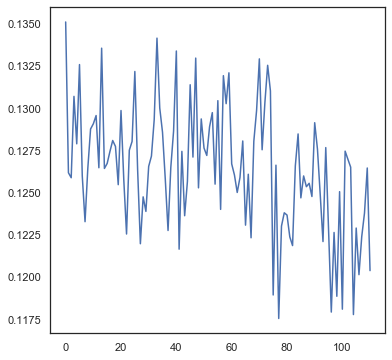

In [0]:
# Plot averaged data
df_regr = pd.DataFrame({'x':x,'y':y})
df_regr = df_regr.groupby(['x']).mean() 
df_regr.shape[0]
assert df_regr.shape[0] == len(np.unique(x))

x = df_regr.index.values
y = df_regr['y'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.plot(x,y)
print('r2:',r_value**2, 'p-value: ',p_value)


# Plot mean values and regression stats

In [0]:
subreddit = 'personalfinance'
summary = timeseries_summary(input_dir, subreddit = subreddit, pre_or_post = 'post', 
                       timestep = 2, metric='mean',weigh_by_Nwords = True, filter_days = False,zscore_slope=False)





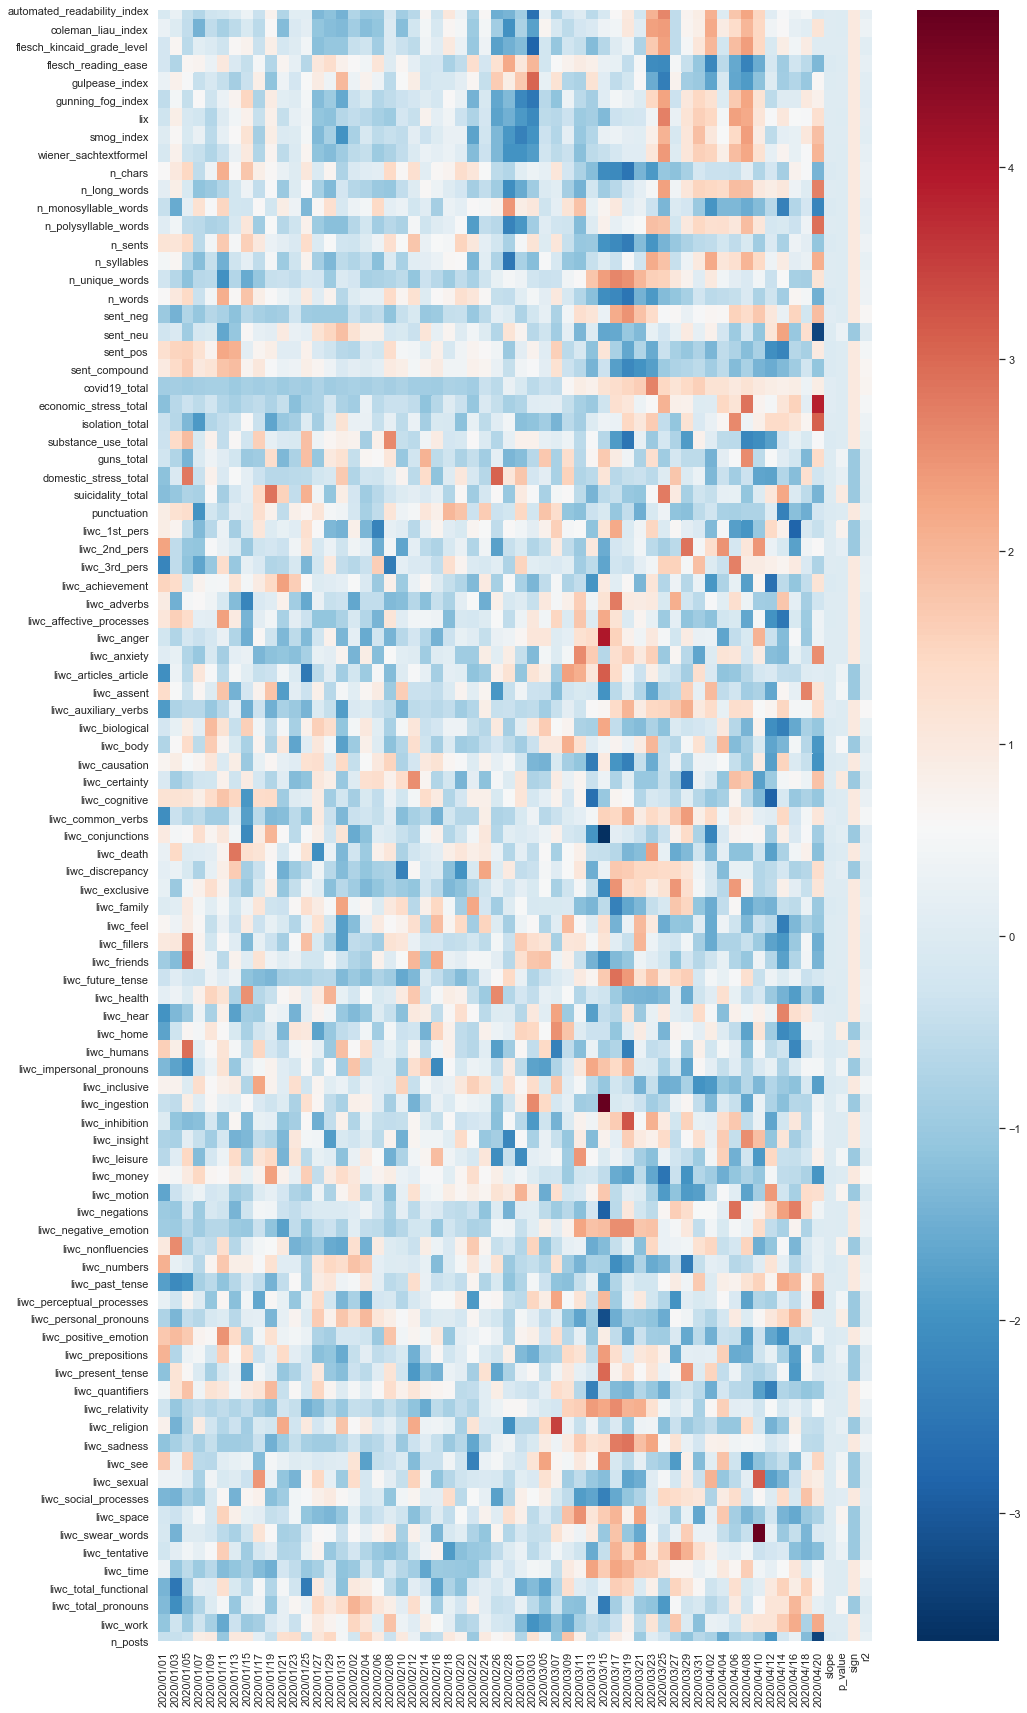

In [0]:
# Plot
sns.set(style='white', rc={'figure.figsize':(16,30)}, font_scale =1)
sns.heatmap(summary, cmap = 'RdBu_r')

In [0]:
# Interpret: Look at words in LIWC features
liwc = pd.read_csv('./../../datum/util_nlp/liwc_english_dictionary/categories.txt', sep=',').iloc[:,1].values

liwc_words = np.load('./../../datum/util_nlp/liwc_english_dictionary/liwc.npy',allow_pickle=True).item()

liwc_words['motion']

## See some features in detail and plot regression line in color for examples


=====sent_pos====


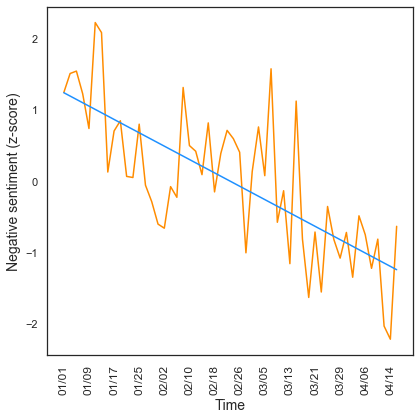

In [0]:
sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)
# for variable in keep:
for variable in ['sent_pos']:
    print('\n====={}===='.format(variable))
    x_name = summary.columns[:-6].values
    x_name = [n.replace('2020/','') for n in x_name]
    x = range(len(x_name))
    y = summary.T[variable][:-6].values
    plt.plot(x_name,y ,color='darkorange')
    plt.title('')
    plt.ylabel('Negative sentiment (z-score)', fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.xticks(np.arange(min(x), max(x)+1, 4),rotation=90, fontsize = 12)
#     plt.xticks(rotation=90)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='dodgerblue')
    plt.tight_layout()
    plt.savefig('./data/trend_example_down_neg_sent.png', dpi=400)
    plt.show()



=====isolation_total====


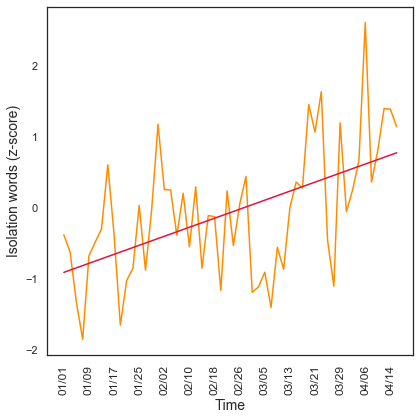

In [0]:
sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)
# for variable in keep:
for variable in ['isolation_total']:
    print('\n====={}===='.format(variable))
    x_name = summary.columns[:-6].values
    x_name = [n.replace('2020/','') for n in x_name]
    x = range(len(x_name))
    y = summary.T[variable][:-6].values
    plt.plot(x_name,y ,color='darkorange')
    plt.title('')
    plt.ylabel('Isolation words (z-score)', fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.xticks(np.arange(min(x), max(x)+1, 4),rotation=90, fontsize = 12)
#     plt.xticks(rotation=90)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='crimson')
    plt.tight_layout()
    plt.savefig('./data/trend_example_up_isolation.png', dpi=400)
    plt.show()


# Main summary figure: slope*r^2 for all features and all subreddits

In [0]:
from statsmodels.stats.multitest import multipletests
import json
from matplotlib.colors import DivergingNorm

In [0]:
def main_table(subreddits, features, timestep =2, pre_or_post = 'post', add_subreddits_to_features=True):
    # If using older data, than we want to filter months to match 2020 data
    if pre_or_post == 'pre':
        filter_days = ['2018/']+ ['2019/04/'+str(n).zfill(2) for n in range(21,31) ]+['2019/'+str(n).zfill(2) for n in range(5,13) ]
    else:
        filter_days = False
    
    slope_all = []
    r2_all = []
    p_value_all = []

    print('loading...')
    for sr in subreddits:
        print(sr)
        summary_sr = timeseries_summary(input_dir, subreddit = sr, pre_or_post = pre_or_post, 
                           timestep = timestep, metric='mean',weigh_by_Nwords = True, zscore_slope =False,filter_days=filter_days)
        summary_sr_slope = summary_sr[['slope']]
        slope_all.append(summary_sr_slope)
        r2_all.append(summary_sr[['r2']]) 
        p_value_all.append(summary_sr[['p_value']])
    
    # Build DF from list of DFs
    df_slope = pd.concat(slope_all, axis=1) 
    df_r2 = pd.concat(r2_all, axis=1) 
    df_p_value = pd.concat(p_value_all, axis=1)

    # Add col name
    df_slope.columns = subreddits
    df_r2.columns = subreddits
    df_p_value.columns = subreddits

    # Filter features
    print('features before filtering: ',df_slope.shape)
    df_slope = df_slope.T[keep].T
    df_r2 = df_r2.T[keep].T
    df_p_value = df_p_value.T[keep].T
    print('features after filtering: ',df_slope.shape)

    # slope * r^2 
    df_slope_r2 = df_slope*df_r2

    # Multiple comparison correction
    pvals= df_p_value.values.flatten() 
    reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

    # Create mask with significant results
    reject_opp = np.array([not c for c in reject]) #inverse mask of booleans
    df_shape = df_p_value.shape # reshape to this shape
    df_reject = pd.DataFrame(reject_opp.reshape(df_shape))
    df_reject.columns = df_slope_r2.columns
    df_reject.index = df_slope_r2.index
    print('Significant results: ',np.sum(reject)/len(reject))
    
    if add_subreddits_to_features:
    # Y-AXIS: Add mental health subreddits that most use each feature for classification (computed only using highest coefficients (top 50%) )
        with open('./../../datum/reddit/output/binary6_model0/main_sr_per_feature.json', 'r') as fp:
            max_features = json.load(fp)

        df_index = df_slope_r2.index 
        # insert into y-axis
        df_index_new = []
        for i in df_index:
            sr = max_features.get(i)
            if sr==None:
                df_index_new.append(''+i)
            else:
                df_index_new.append('({})   '.format(sr)+i)

        df_slope_r2.index = df_index_new
        df_.index = df_index_new
    
    return df_slope_r2, df_reject


    

In [0]:

def plot_trend_heatmap(df, mask, plot_name, savefig = True):

  plt.clf()
  sns.set(style='white', rc={'figure.figsize':(17,20)}, font_scale =1)
  cmap = plt.get_cmap("RdBu_r")
  cmap.set_bad(color='white', alpha=0.1)
  # Make sure 0 is white, use same color scale as 1st figure.
  divnorm = DivergingNorm(vcenter=0)
  sns.heatmap(df, norm=divnorm, cmap =cmap,cbar = False,linewidths=0) #this one appears in the background masked 
  ax = sns.heatmap(df, cmap=cmap,norm=divnorm, cbar = False,mask=mask, linewidths=0.1,
              annot=True,annot_kws={"fontsize":10}, vmin=-0.045, vmax=0.045) #this one is for the 


  # So it won't get cutoff
  bottom, top = ax.get_ylim()
  ax.set_ylim(bottom + 0.5, top - 0.5)
  ax.tick_params(axis='x', which='major', labelsize=12)
  ax.tick_params(axis='y', which='major', labelsize=10)

  plt.ylabel('Features (important feature to classify this subreddit)',fontsize=15)
  plt.xlabel('Subreddits', fontsize=15)
  plt.tight_layout()
  if savefig:
    plt.savefig(output_dir+f'trends/{plot_name}.png', dpi=400)

In [0]:
# Load 2020
sns.set(style='white', rc={'figure.figsize':(17,20)}, font_scale =1)
pre_or_post = 'post'
add_subreddits_to_features=False
df_slope_r2, df_reject = main_table(subreddits, keep, pre_or_post = pre_or_post, add_subreddits_to_features=add_subreddits_to_features)

loading...
COVID19_support
(29, 92)
mentalhealth
(56, 92)
anxiety
(56, 92)
socialanxiety
(56, 92)
healthanxiety
(56, 92)
autism
(56, 92)
adhd
(56, 92)
ptsd
(56, 92)
lonely
(56, 92)
depression
(56, 92)
suicidewatch
(56, 92)
bipolarreddit
(56, 92)
bpd
(56, 92)
schizophrenia
(56, 92)
addiction
(56, 92)
alcoholism
(56, 92)
EDAnonymous
(56, 92)
personalfinance
(56, 92)
conspiracy
(56, 92)
guns
(56, 92)
legaladvice
(56, 92)
divorce
(56, 92)
relationships
(56, 92)
parenting
(56, 92)
teaching
(56, 92)
meditation
(56, 92)
fitness
(56, 92)
jokes
(56, 92)
features before filtering:  (92, 28)
features after filtering:  (92, 28)
Significant results:  0.13819875776397517


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning:


The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.



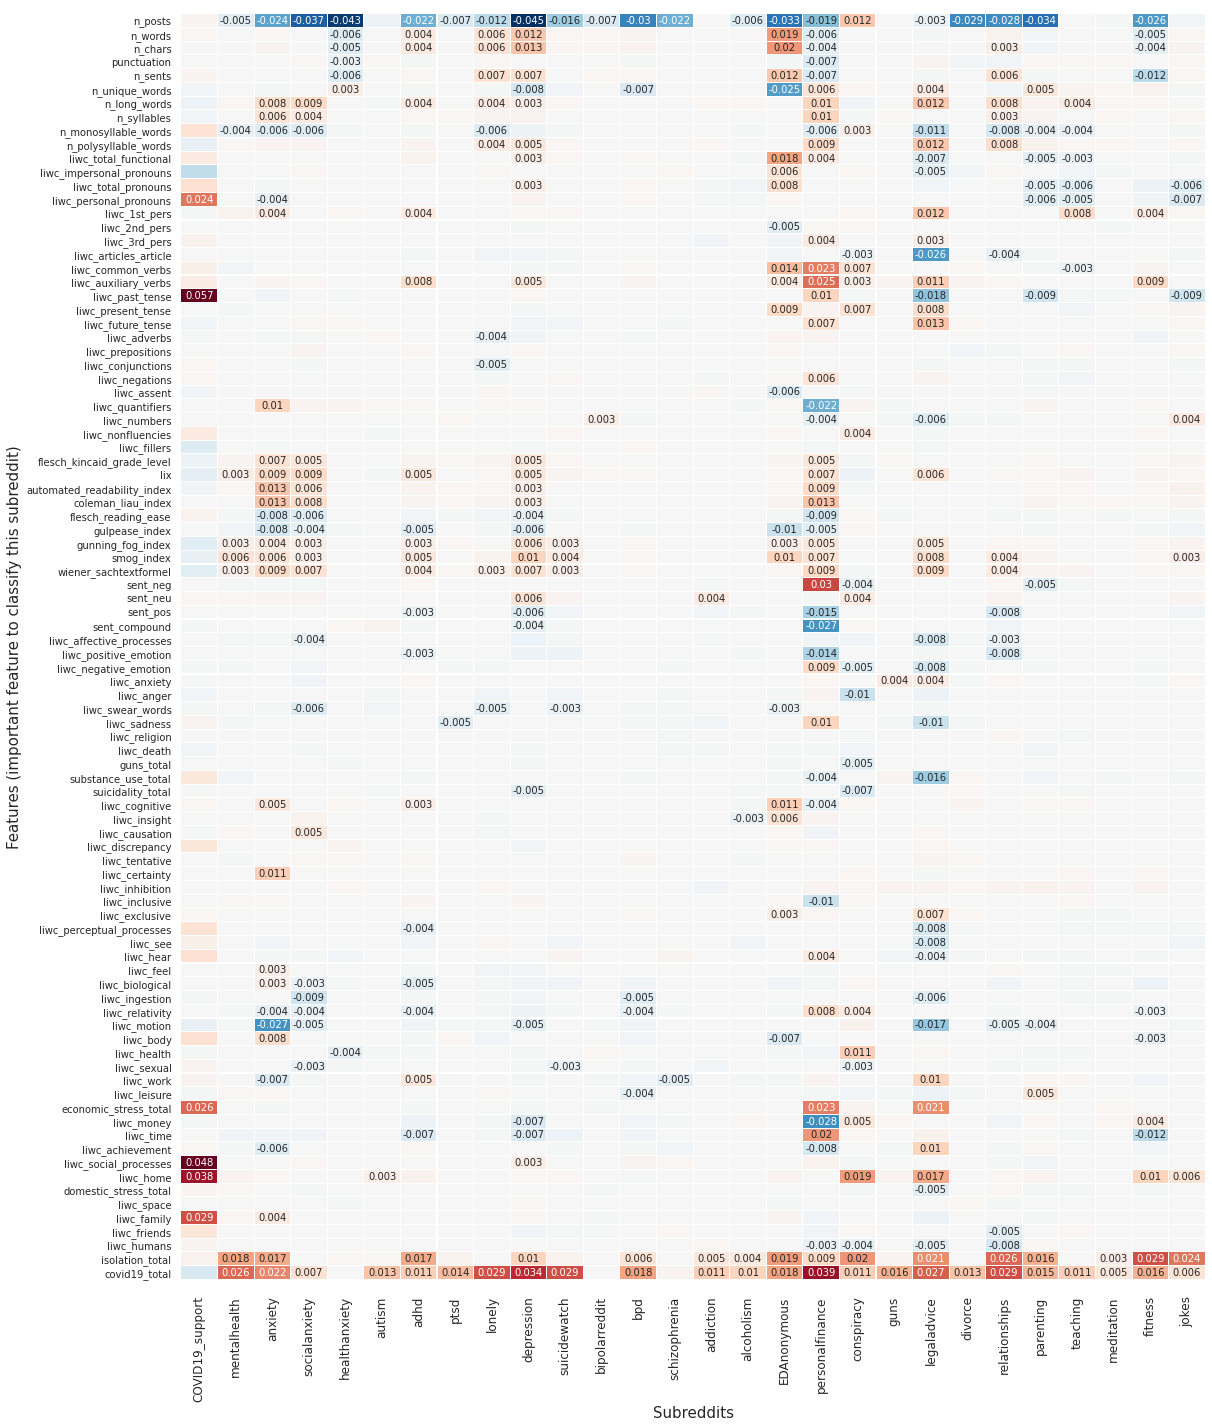

In [0]:
# Plot 2020
pre_or_post = 'post'
plot_name = f'heatmap_slope_r2_bh_{pre_or_post}_main'
df = df_slope_r2.copy().round(3)
mask = df_reject.copy()
plot_trend_heatmap(df, mask, plot_name, savefig = True)

In [0]:
# Load from 2019
pre_or_post = '2019'
add_subreddits_to_features=False
subreddits_pre = subreddits.copy()
subreddits_pre.remove('COVID19_support')
df_slope_r2_2019, df_reject_2019 = main_table(subreddits_pre, keep, pre_or_post = pre_or_post, add_subreddits_to_features=add_subreddits_to_features)


loading...
mentalhealth
(55, 92)
anxiety
(55, 92)
socialanxiety
(55, 92)
healthanxiety
(55, 92)
autism
(55, 92)
adhd
(55, 92)
ptsd
(55, 92)
lonely
(55, 92)
depression
(55, 92)
suicidewatch
(55, 92)
bipolarreddit
(55, 92)
bpd
(55, 92)
schizophrenia
(55, 92)
addiction
(55, 92)
alcoholism
(55, 92)
EDAnonymous
(55, 92)
personalfinance
(55, 92)
conspiracy
(55, 92)
guns
(55, 92)
legaladvice
(55, 92)
divorce
(55, 92)
relationships
(55, 92)
parenting
(55, 92)
teaching
(54, 92)
meditation
(55, 92)
fitness
(55, 92)
jokes
(55, 92)
features before filtering:  (92, 27)
features after filtering:  (92, 27)
Significant results:  0.01892109500805153


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning:


The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.



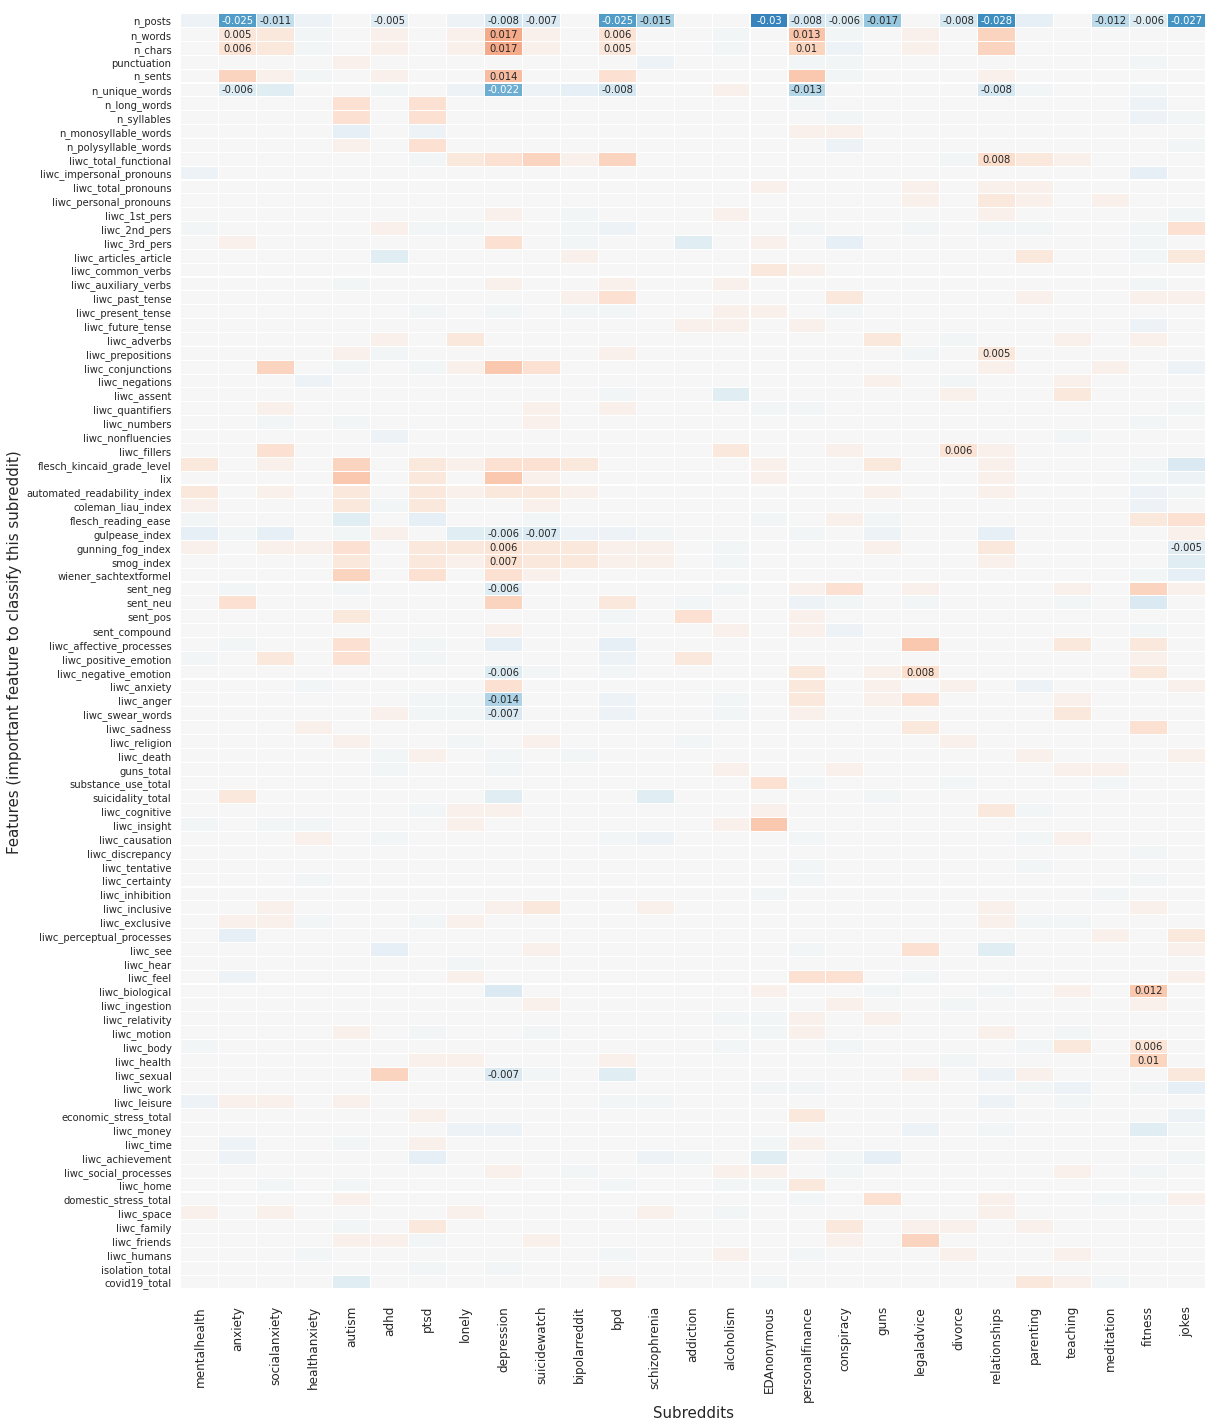

In [0]:
# Plot 2019
pre_or_post = '2019'
plot_name = f'heatmap_slope_r2_bh_{pre_or_post}_main'
df = df_slope_r2_2019.copy().round(3)
mask = df_reject_2019.copy() #df_reject or False
plot_trend_heatmap(df, mask, plot_name, savefig = True)



In [0]:
# Load 2018
pre_or_post = '2018'
add_subreddits_to_features=False
subreddits_pre = subreddits.copy()
subreddits_pre.remove('COVID19_support')
subreddits_pre.remove('EDAnonymous') #Created Nov. 18, 2018, so there's no data. 
df_slope_r2_2018, df_reject_2018 = main_table(subreddits_pre, keep, pre_or_post = pre_or_post, add_subreddits_to_features=add_subreddits_to_features)





loading...
mentalhealth
(55, 92)
anxiety
(55, 92)
socialanxiety
(55, 92)
healthanxiety
(54, 92)
autism
(55, 92)
adhd
(55, 92)
ptsd
(55, 92)
lonely
(55, 92)
depression
(55, 92)
suicidewatch
(55, 92)
bipolarreddit
(55, 92)
bpd
(55, 92)
schizophrenia
(55, 92)
addiction
(55, 92)
alcoholism
(53, 92)
personalfinance
(55, 92)
conspiracy
(55, 92)
guns
(55, 92)
legaladvice
(55, 92)
divorce
(55, 92)
relationships
(55, 92)
parenting
(55, 92)
teaching
(55, 92)
meditation
(55, 92)
fitness
(55, 92)
jokes
(55, 92)
features before filtering:  (92, 26)
features after filtering:  (92, 26)
Significant results:  0.013795986622073578


In [0]:
# Plot 2018
plot_name = f'heatmap_slope_r2_bh_{pre_or_post}_main'
df = df_slope_r2_2018.copy().round(3)
mask = df_reject_2018.copy() #df_reject or False
plot_trend_heatmap(df, mask, plot_name, savefig = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning:


The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.



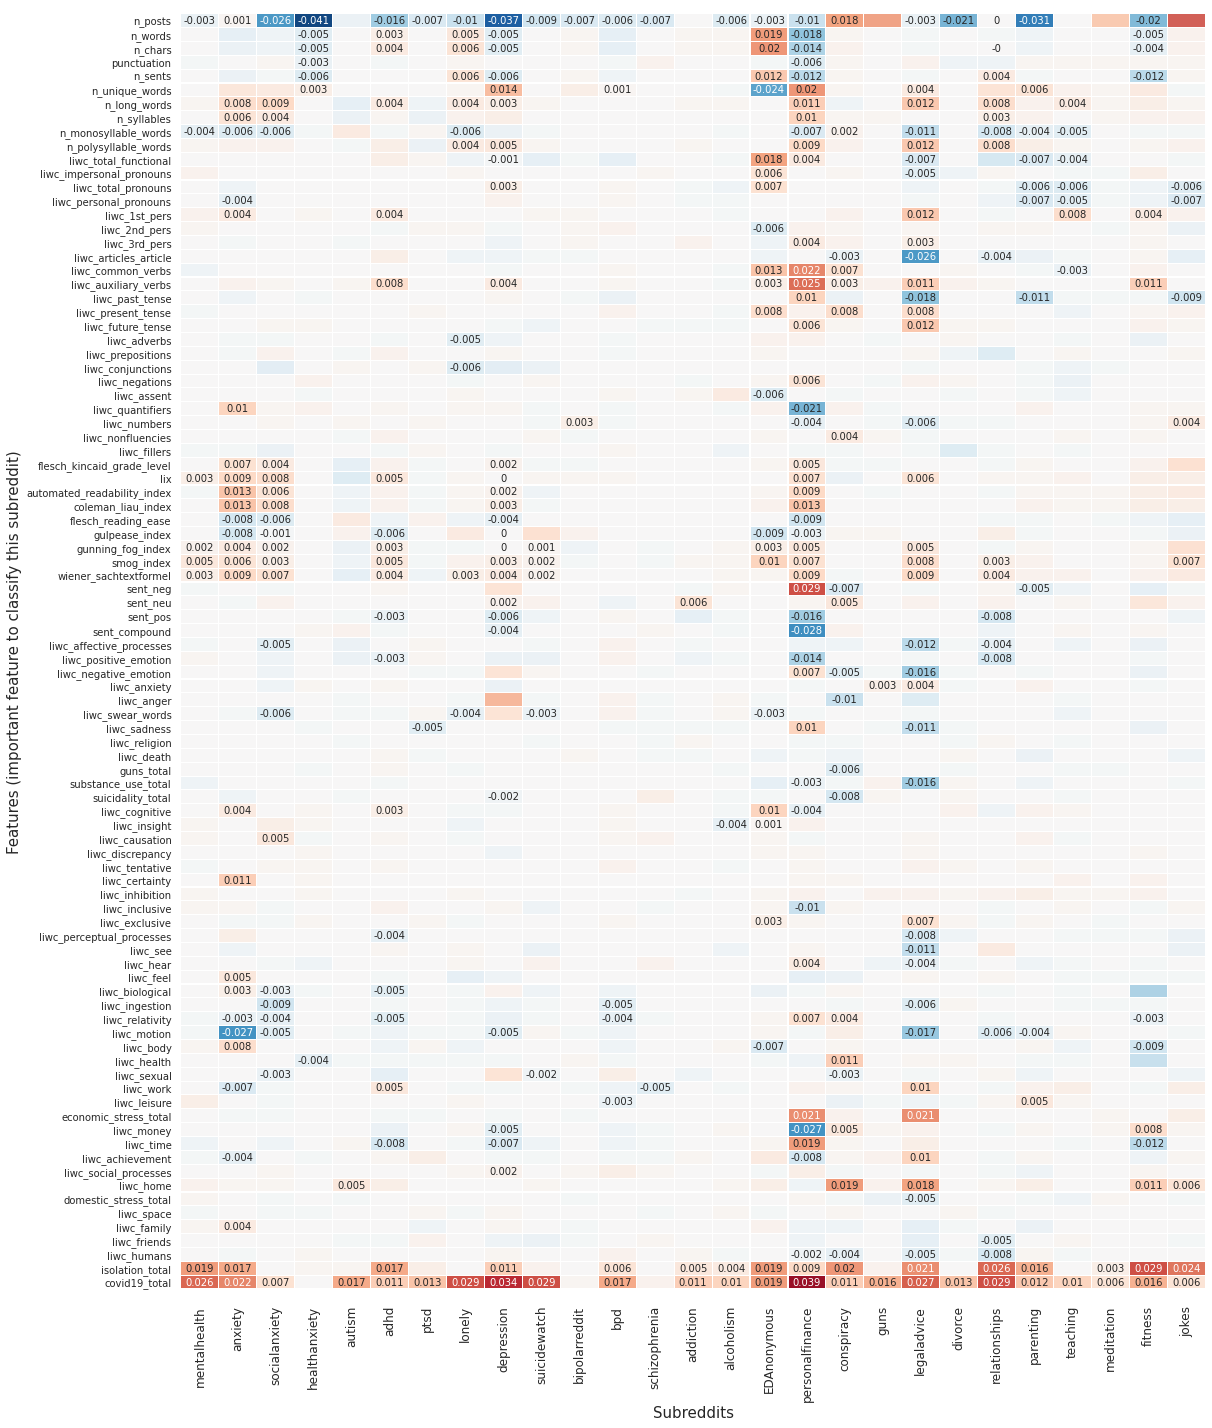

In [0]:
# Subtract 2020-2019 
# Plot
pre_or_post = '2020-2019'
plot_name = f'heatmap_slope_r2_bh_{pre_or_post}_main'

df_slope_r2_2020 = df_slope_r2.copy() 
del df_slope_r2_2020['COVID19_support']
df = df_slope_r2_2020 - df_slope_r2_2019
df = df.round(3)
mask = df_reject.copy() #df_reject or False
del mask['COVID19_support']
plot_trend_heatmap(df, mask, plot_name, savefig = True)





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning:


The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.



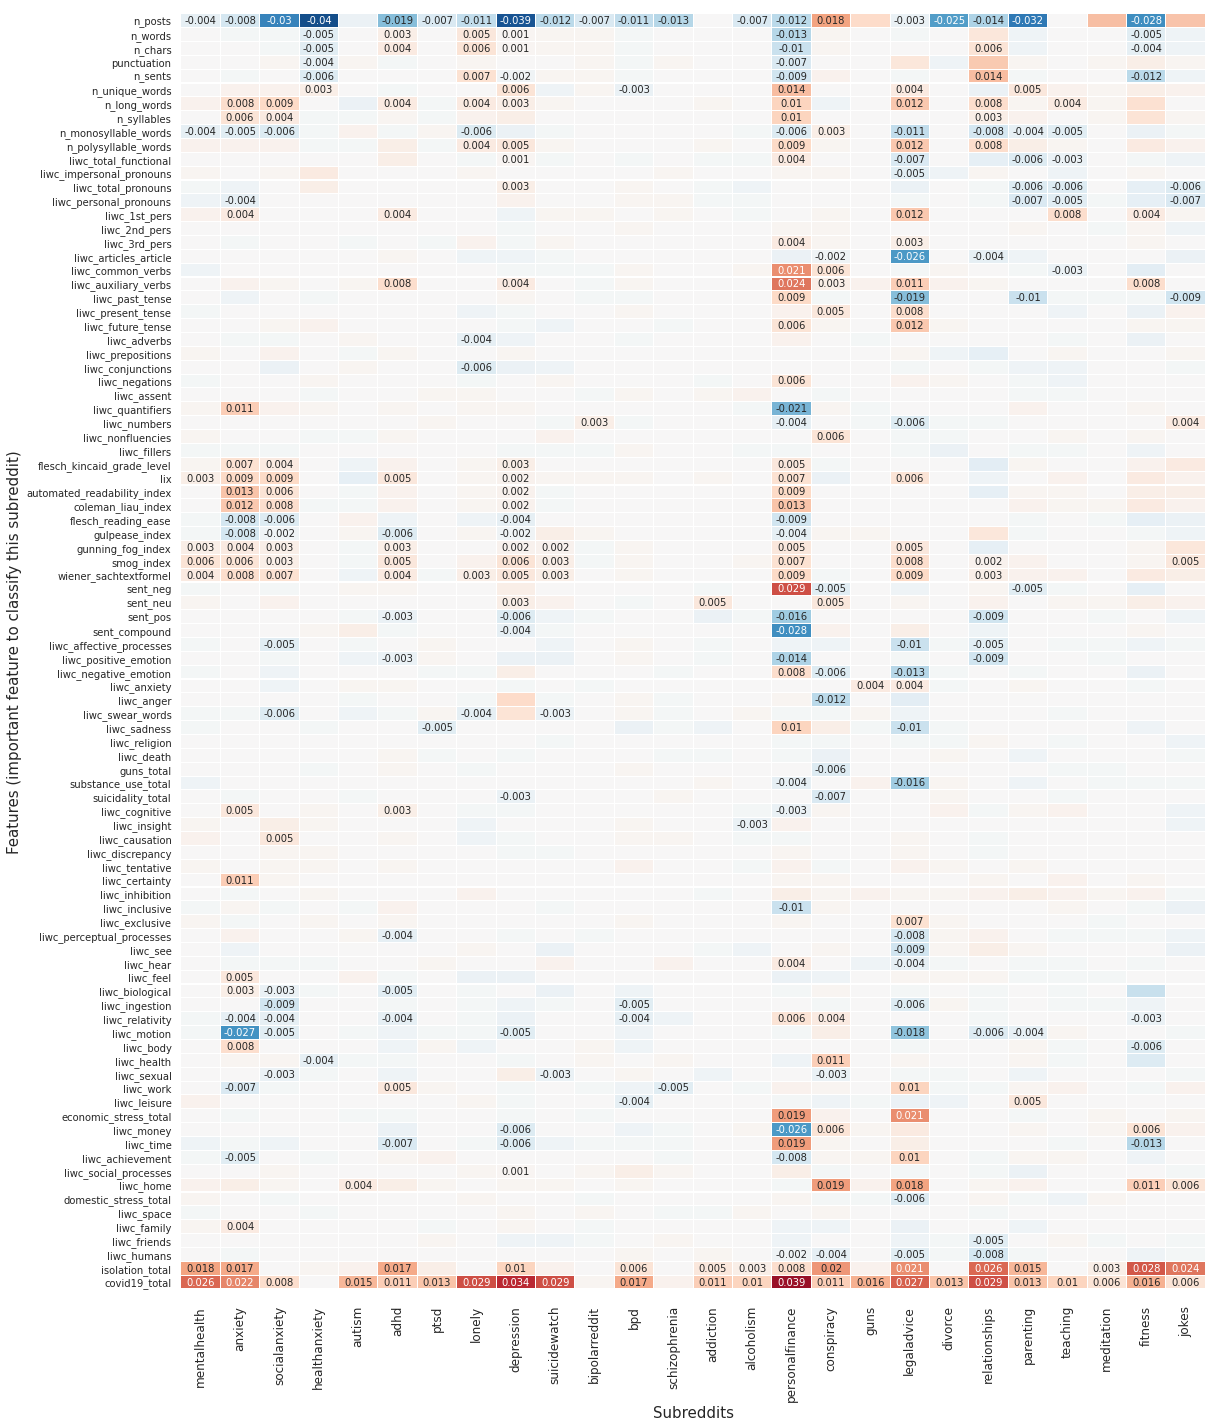

In [0]:
# Subtract 2020- mean(2019,2018)
# Plot
pre_or_post = '2020-pre2019_2018'
plot_name = f'heatmap_slope_r2_bh_{pre_or_post}_main'

# 2020
df_slope_r2_2020 = df_slope_r2.copy() 
del df_slope_r2_2020['COVID19_support']
del df_slope_r2_2020['EDAnonymous']

# Mean of 2019 and 2018 wo EDAnonymous
df_slope_r2_2019_wo_ED = df_slope_r2_2019.copy()
del df_slope_r2_2019_wo_ED['EDAnonymous']
df_mean_pre = pd.DataFrame(np.mean((df_slope_r2_2019_wo_ED.values,df_slope_r2_2018.values), axis=0))
df_mean_pre.columns = df_slope_r2_2020.columns
df_mean_pre.index = df_slope_r2_2020.index

# Substraction
df = df_slope_r2_2020 - df_mean_pre
df = df.round(3)
mask = df_reject.copy() #df_reject or False
del mask['COVID19_support']
del mask['EDAnonymous']

plot_trend_heatmap(df, mask, plot_name, savefig = True)


2842969.0 0.6457925334145601


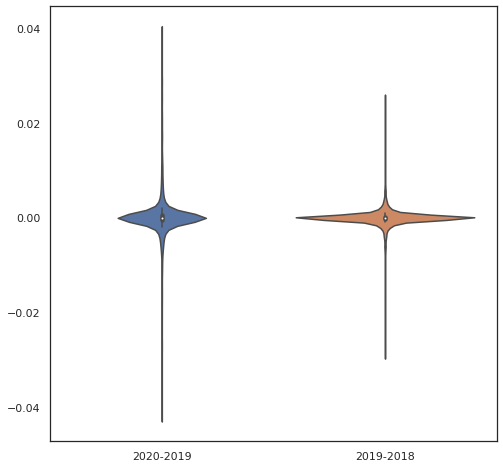

In [0]:
# Boxplot (2020-2019) - (2019-2018)
pre_or_post = 'boxplot_post_vs_pre'
# Subtract 2020- mean(2019,2018)
# Plot
pre_or_post = '2020-pre2019_2018'
plot_name = f'heatmap_slope_r2_bh_{pre_or_post}_main'

# 2020
df_slope_r2_2020 = df_slope_r2.copy() 
del df_slope_r2_2020['COVID19_support']
del df_slope_r2_2020['EDAnonymous']

# 2019
df_slope_r2_2019_wo_ED = df_slope_r2_2019.copy()
del df_slope_r2_2019_wo_ED['EDAnonymous']

# 2018
df_slope_r2_2018

# Substraction
df_post = df_slope_r2_2020 - df_slope_r2_2019_wo_ED
df_pre = df_slope_r2_2019_wo_ED - df_slope_r2_2018


# Boxplot
sns.set(style='white', rc={'figure.figsize':(8,8)}, font_scale =1)
post_flat = df_post.values.flatten()
pre_flat = df_pre.values.flatten()
y = np.concatenate((post_flat,pre_flat))
x = ['2020-2019']*len(post_flat) + ['2019-2018']*len(pre_flat) 
sns.violinplot(x = x , y = y)

s,p = mannwhitneyu(post_flat, pre_flat, alternative='greater')
print(s,p)




Whitney U (3374549.0) = 2.8055124137635058e-27


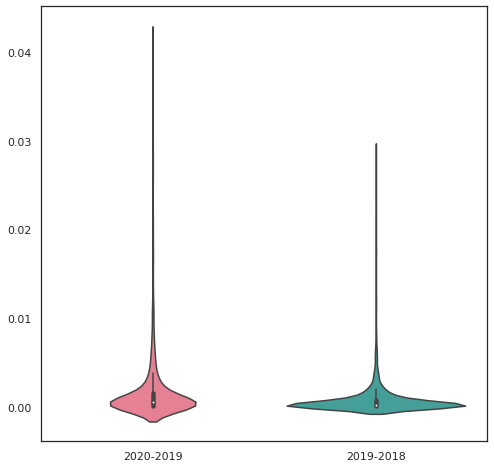

In [0]:
from scipy.stats import mannwhitneyu

# Boxplot
sns.set(style='white', rc={'figure.figsize':(8,8)}, font_scale =1)
post_flat = np.abs(df_post.values.flatten())
pre_flat = np.abs(df_pre.values.flatten())
y = np.concatenate((post_flat,pre_flat))
x = ['2020-2019']*len(post_flat) + ['2019-2018']*len(pre_flat) 
sns.violinplot(x = x , y = y, palette='husl')


s,p = mannwhitneyu(post_flat, pre_flat, alternative='greater')
print(f'Whitney U ({s}) = {p}')

# Which mental health subreddits changed most?
Sum r^2 across features for each


In [0]:


df_top_effects = df.copy() #2020-2019

top_effects_all = df_top_effects[~df_reject].abs().sum().sort_values()[::-1].round(3)
top_effects_all = top_effects_all.reset_index()
top_effects_all.columns = ['subreddit', 'Σ |slope| x R^2\n all features']
top_effects_all


# Weigh negatively 'sent_compound', 'sent_pos','liwc_positive_emotion',

# Look at only negative features
features = [ 
    'sent_compound', 'sent_pos','liwc_positive_emotion', #weigh pos features * -1
    'sent_neg', 'economic_stress_total',
       'isolation_total', 'substance_use_total', 'guns_total',
       'domestic_stress_total', 'suicidality_total',  
'liwc_anger',
       'liwc_anxiety',  'liwc_death', 'liwc_negations',
       'liwc_negative_emotion','liwc_sadness', ]
df_filtered2 = df_top_effects.T[features].T

for feature in ['sent_compound', 'sent_pos','liwc_positive_emotion']:
    df_filtered2.loc[feature] = df_filtered2.loc[feature] * -1


top_effects_emotional = df_filtered2[~df_reject].sum().sort_values()[::-1].round(3)
top_effects_emotional = top_effects_emotional.reset_index()
top_effects_emotional.columns = ['subreddit', 'Σ slope x R^2\n neg. emotional features']
top_effects_emotional


subreddit  Σ slope x R^2\n neg. emotional features
0   personalfinance                                    0.137
1     relationships                                    0.042
2           fitness                                    0.029
3             jokes                                    0.024
4              adhd                                    0.023
5       EDAnonymous                                    0.019
6      mentalhealth                                    0.019
7        depression                                    0.019
8           anxiety                                    0.017
9         parenting                                    0.011
10              bpd                                    0.006
11        addiction                                    0.005
12       alcoholism                                    0.004
13       meditation                                    0.003
14             guns                                    0.003
15           lonely                                    0.000
16    socialanxiety                                    0.000
17    healthanxiety                                    0.000
18           autism                                    0.000
19     suicidewatch                                    0.000
20    bipolarreddit                                    0.000
21    schizophrenia                                    0.000
22         teaching                                    0.000
23          divorce                                    0.000
24      legaladvice                                   -0.002
25             ptsd                                   -0.005
26       conspiracy                                   -0.016

In [0]:
top_effects  = pd.concat([top_effects_all, top_effects_emotional], axis=1)
print(top_effects.to_latex(index=False))

\begin{tabular}{lrlr}
\toprule
       subreddit &  Σ |slope| x R\textasciicircum 2\textbackslash n all features &        subreddit &  Σ slope x R\textasciicircum 2\textbackslash n neg. emotional features \\
\midrule
 personalfinance &                           0.565 &  personalfinance &                                    0.150 \\
      conspiracy &                           0.492 &    relationships &                                    0.070 \\
 COVID19\_support &                           0.454 &  COVID19\_support &                                    0.044 \\
     legaladvice &                           0.452 &             adhd &                                    0.032 \\
     EDAnonymous &                           0.342 &       depression &                                    0.031 \\
   relationships &                           0.247 &            jokes &                                    0.028 \\
         anxiety &                           0.217 &          fitness &               

## Select subset of table for presentation

In [0]:
subreddits

['addiction',
 'guns',
 'socialanxiety',
 'schizophrenia',
 'healthanxiety',
 'suicidewatch',
 'EDAnonymous',
 'mentalhealth',
 'COVID19_support',
 'teaching',
 'fitness',
 'personalfinance',
 'meditation',
 'bipolarreddit',
 'adhd',
 'conspiracy',
 'autism',
 'mentalillness',
 'alcoholism',
 'bpd',
 'ptsd',
 'divorce',
 'legaladvice',
 'jokes',
 'mindfulness',
 'anxiety',
 'depression',
 'parenting',
 'relationships',
 'lonely']

In [0]:

features4 = ['n_posts','n_words','sent_neg', 'sent_pos','economic_stress_total', 'isolation_total',
             'liwc_motion', 'liwc_home','liwc_body','liwc_past_tense',]

features4 = ['n_posts','n_words','sent_neg', 'sent_pos','economic_stress_total', 'isolation_total',
             'liwc_motion', 'liwc_home']

subreddits4 = [
     'COVID19_support',
 'anxiety',
     'socialanxiety',
     'healthanxiety',
     'depression',
 'suicidewatch',    
 'EDAnonymous',

 'personalfinance',
 'relationships',
 'guns',
]



In [0]:
features=keep.copy() #all features


# Filter subreddits
df_slope_filtered = df_slope[subreddits3]
df_p_value_filtered = df_p_value[subreddits3]
df_r2_filtered =df_r2[subreddits3]

# Filter features
df_slope_filtered = df_slope_filtered.T[features].T
df_p_value_filtered = df_p_value_filtered.T[features].T
df_r2_filtered = df_r2_filtered.T[features].T



# NEW r**2 multiple by the sign of the slope (1 or -1)
df_r2_signed = df_r2_filtered * df_slope_filtered

# OLD: # r**2 multiple by the sign of the slope (1 or -1)
# df_r2_signed = df_r2_filtered * ( df_slope_filtered/np.abs(df_slope_filtered))

# filter features
df_filtered = df_r2_signed.T[keep].T


In [0]:
df_filtered_shape = df_filtered.shape
df_filtered_shape

# Multiple comparison correction
pvals= df_p_value_filtered.values.flatten()
reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

# Create mask
reject_opp = np.array([not c for c in reject])
df_reject = pd.DataFrame(reject_opp.reshape(df_filtered_shape))
df_reject.columns = df_filtered.columns
df_reject.index = df_filtered.index


In [0]:
# filter subreddits
df_filtered4 = df_filtered[subreddits4]
df_reject4 = df_reject[subreddits4]

# filter features
df_filtered4 = df_filtered4.T[features4].T
df_reject4 = df_reject4.T[features4].T


In [0]:
new_index = df_filtered4.index
new_index = [n.replace('liwc_','').replace('_total','').replace('sent_', 'sentiment ').replace('_', ' ') for n in new_index]
# new_columns = [n.replace('liwc_','').replace('_total','').replace('sent_', 'sentiment ').replace('_', ' ') for n in new_index]

df_reject4.index = new_index
df_filtered4.index = new_index

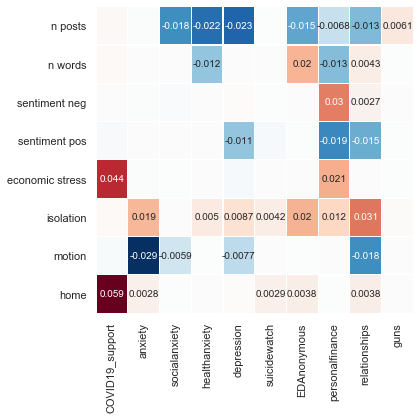

In [0]:
# Plot

sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)
cmap = plt.get_cmap("RdBu_r")
cmap.set_bad(color='white', alpha=0.65)
plt.clf()
divnorm = DivergingNorm(vmin=df_filtered.min().min(), vcenter=0, vmax=df_filtered.max().max())
sns.heatmap(df_filtered4, norm=divnorm, cmap ="RdBu_r",cbar = False,linewidths=0.1)

# mask
ax = sns.heatmap(df_filtered4, cmap=cmap, norm=divnorm,  cbar = False,mask=df_reject4, linewidths=0.1,
            annot=True,annot_kws={"fontsize":10})


bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
# plt.title('R^2 * sign of the slope')
plt.tight_layout()
# plt.ylabel('Features (important feature to classify this subreddit)',fontsize=15)
# plt.xlabel('Subreddits', fontsize=15)

plt.savefig('./data/heatmap_r2_everything_bh_small_v2.png', dpi=400)

## Classification: measure amount of user repeats

In [0]:
reddit_data = load_reddit.multiclass(input_dir, subreddits, pre_or_post = 'pre')

'''
# Check how many authors are in both train and test set

X = reddit_data.author.values
y = reddit_data.subreddit.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234)


from collections import Counter
Counter(X)


unique_posts = len(np.unique(X))/len(X)

repeated = [author for author in X_test if author in X_train]
repeated_proportion = len(repeated)/len(X_test)


# 




In [0]:

def subsample_df(df, subsample):
	if type(subsample) == float:
		subsample = int(df.shape[0]*subsample)
	df = df.reset_index(drop=True)
	df2 = df.loc[np.random.choice(df.index,subsample, replace=False)]
	return df2

In [0]:

def load_reddit(subreddits, data_folder='./', subsample = 5600,pre_or_post = 'pre'):

    # subsample = 5600 #False, int for balanced, or 0.1 for unbalanced proportion, 5600
    # subsample_subreddits_overN = 25000 #subsample if dataset > N, set to 0 for all

    # Careful: if you add COVID19_support and it does not exist in the first time step, then this will confuse metric learning
    subreddits.sort()
    # Main features
    # Load first subreddit to build DF
    reddit_data = pd.read_csv(data_folder + 'feature_extraction/new/'+subreddits[0]+'_{}_features.csv'.format(pre_or_post), index_col=False)
    days = np.unique(reddit_data.date)
    days_jan_feb = [n for n in days if '2020/01' in n or '2020/02' in n]
    days_jan_feb
    # Concat tfidf features
    # reddit_data_tfidf = pd.read_csv(data_folder + 'tfidf_vector/'+subreddits[0]+'_{}_tfidf256.csv'.format(pre_or_post), index_col=False)
    # reddit_data = reddit_data.merge(reddit_data_tfidf) ##inner is default, will elimante rows not shared on shared cols (post, author, etc, date)\n",

    # remove jan and feb data from covid19_support because there's not enough data and if not kmeans will assign two centroids to another larger subreddit
    if subreddits[0]=='COVID19_support':
      reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]


    print(reddit_data.shape)
    # Subsample to int or subsample float

    if subsample and subreddits[0] !='COVID19_support':
        reddit_data = subsample_df(reddit_data, subsample)
        print(reddit_data.shape)

    # Add next subreddits
    for i in np.arange(1, len(subreddits)):
        print('===')
        print(subreddits[i])
        new_data = pd.read_csv(data_folder + 'feature_extraction/new/'+subreddits[i]+'_{}_features.csv'.format(pre_or_post), index_col=False)
        # new_data_tfidf = pd.read_csv(data_folder + 'tfidf_vector/'+subreddits[i]+'_{}_tfidf256.csv'.format(pre_or_post), index_col=False)
        # new_data = new_data.merge(new_data_tfidf) ##inner is default, will elimante rows not shared on shared cols (post, author, etc, date)\n",
        if subreddits[i]=='COVID19_support':
          reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]
        print(new_data.shape)
        if subsample and subreddits[i] !='COVID19_support':
            new_data = subsample_df(new_data, subsample)
            print(new_data.shape)
        reddit_data = pd.concat([reddit_data, new_data], axis=0)

    return reddit_data


In [0]:
subreddits = ['addiction','EDAnonymous','adhd','autism','alcoholism', 'bipolarreddit', 'depression', 'anxiety','healthanxiety', 'lonely', 'schizophrenia', 'socialanxiety', 'suicidewatch']
data_folder = './../../datum/reddit/input/'
subsample = 5600
reddit_data = load_reddit(subreddits, data_folder=data_folder, subsample = subsample,pre_or_post = 'pre')

(30122, 351)
(5600, 351)
===
addiction
(6406, 351)
(5600, 351)
===
adhd
(30095, 351)
(5600, 351)
===
alcoholism
(5654, 351)
(5600, 351)
===
anxiety
(30155, 351)
(5600, 351)
===
autism
(7860, 351)
(5600, 351)
===
bipolarreddit
(7252, 351)
(5600, 351)
===
depression
(30318, 351)
(5600, 351)
===
healthanxiety
(11640, 351)
(5600, 351)
===
lonely
(20638, 351)
(5600, 351)
===
schizophrenia
(12545, 351)
(5600, 351)
===
socialanxiety
(21782, 351)
(5600, 351)
===
suicidewatch
(30373, 351)
(5600, 351)


In [0]:
from sklearn.model_selection import train_test_split
from collections import Counter

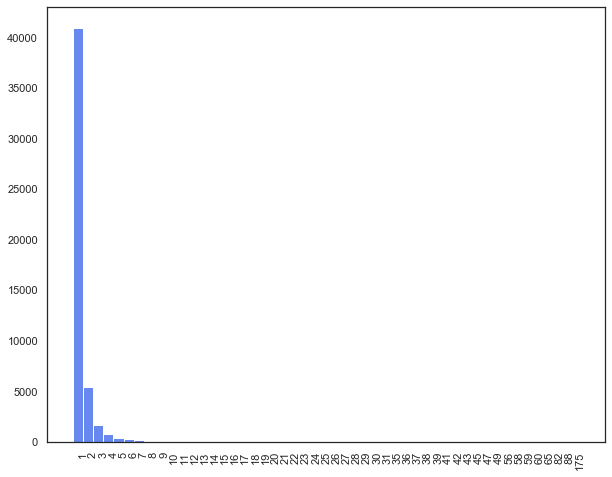

unique posts 0.6914148351648352


In [0]:
# Check how many authors are in both train and test set

X = reddit_data.author.values
y = reddit_data.subreddit.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234)


repeated_posters = Counter(X).values()
histogram(Counter(X).values())

unique_posts = len(np.unique(X))/len(X)
print(f'unique posts {unique_posts}')





In [0]:
# The whole training set 
print(Counter(X).most_common()[:5])
top_poster0 = Counter(X).most_common()[0][0]
top_poster1 = Counter(X).most_common()[1][0]
print(top_poster0)
print([n[:50] for n in reddit_data[reddit_data.author==top_poster0].post.values[:10]])
print(reddit_data[reddit_data.author==top_poster0].subreddit.values[:30])
print([n[:50] for n in reddit_data[reddit_data.author==top_poster1].post.values[:10]])
print(reddit_data[reddit_data.author==top_poster1].subreddit.values[:30])


[('askaboutaa', 175), ('littymcwork', 88), ('jibberjabbery', 82), ('Rhys345', 65), ('EDAnonymous_Bot', 60)]
askaboutaa
['Grapevine Daily Quote April 5 "I  learned ... that', 'Grapevine Daily Quote January 31 "We   well know t', 'Grapevine Daily Quote January 1 "If  humility can ', 'Grapevine Daily Quote December 12 "Coincidences ar', 'Grapevine Daily Quote March 26 "As  AA grows, it i', 'Grapevine Daily Quote February 20 "In  the meeting', 'Grapevine Daily Quote March 28 "One  of the first ', 'Grapevine Daily Quote February 7 "Be willing to be', 'Grapevine Daily Quote March 29 "Until  I was at my', 'Grapevine Daily Quote January 4 "As I trudge the R']
['alcoholism' 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism'
 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism'
 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism'
 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism'
 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism'
 'alcoholi

## These are quotes need to be removed. Also would be interesting to see what characterizes people post a lot.  Or in which subreddits are there the most cases of top posters. Do people start posting a lot all of a sudden?


2019 is also from 2018 November?

In [0]:
repeated = [author for author in X_test if author in X_train]
repeated_proportion = len(repeated)/len(X_test)


In [0]:
print(f'repeated_proportion: {repeated_proportion}')

repeated_proportion: 0.4058379120879121


In [0]:
#If we remove top posters, then what is the repeated proportion
repeated_posters = [n for n in Counter(X).most_common() if n[1]>1]
print(f'amount of authors with > 1 post: {len(repeated_posters)/len(X)}')



amount of authors with > 1 post: 0.12847527472527473


In [0]:
# Remove posters > 1
print(reddit_data.shape)
reddit_data_drop_duplicates = reddit_data.drop_duplicates(subset='author', keep='first')
print(reddit_data_drop_duplicates.shape)
reddit_data_drop_duplicates.head()
reddit_data_drop_duplicates.groupby('subreddit').count()



(72800, 351)
(50335, 351)


author  date  post  automated_readability_index  \
subreddit                                                        
EDAnonymous      2945  2945  2945                         2945   
addiction        4278  4278  4278                         4278   
adhd             4693  4693  4693                         4693   
alcoholism       3981  3981  3981                         3981   
anxiety          4919  4919  4919                         4919   
autism           3854  3854  3854                         3854   
bipolarreddit    2501  2501  2501                         2501   
depression       4928  4928  4928                         4928   
healthanxiety    2708  2708  2708                         2708   
lonely           4265  4265  4265                         4265   
schizophrenia    2537  2537  2537                         2537   
socialanxiety    4131  4131  4131                         4131   
suicidewatch     4595  4595  4595                         4595   

               coleman_liau_index  flesch_kincaid_grade_level  \
subreddit                                                       
EDAnonymous                  2945                        2945   
addiction                    4278                        4278   
adhd                         4693                        4693   
alcoholism                   3981                        3981   
anxiety                      4919                        4919   
autism                       3854                        3854   
bipolarreddit                2501                        2501   
depression                   4928                        4928   
healthanxiety                2708                        2708   
lonely                       4265                        4265   
schizophrenia                2537                        2537   
socialanxiety                4131                        4131   
suicidewatch                 4595                        4595   

               flesch_reading_ease  gulpease_index  gunning_fog_index   lix  \
subreddit                                                                     
EDAnonymous                   2945            2945               2945  2945   
addiction                     4278            4278               4278  4278   
adhd                          4693            4693               4693  4693   
alcoholism                    3981            3981               3981  3981   
anxiety                       4919            4919               4919  4919   
autism                        3854            3854               3854  3854   
bipolarreddit                 2501            2501               2501  2501   
depression                    4928            4928               4928  4928   
healthanxiety                 2708            2708               2708  2708   
lonely                        4265            4265               4265  4265   
schizophrenia                 2537            2537               2537  2537   
socialanxiety                 4131            4131               4131  4131   
suicidewatch                  4595            4595               4595  4595   

               ...  tfidf_without  tfidf_wonder  tfidf_work  tfidf_world  \
subreddit      ...                                                         
EDAnonymous    ...           2945          2945        2945         2945   
addiction      ...           4278          4278        4278         4278   
adhd           ...           4693          4693        4693         4693   
alcoholism     ...           3981          3981        3981         3981   
anxiety        ...           4919          4919        4919         4919   
autism         ...           3854          3854        3854         3854   
bipolarreddit  ...           2501          2501        2501         2501   
depression     ...           4928          4928        4928         4928   
healthanxiety  ...           2708          2708        2708         2708   
lonely         ...        

In [0]:

X = reddit_data_drop_duplicates.author.values
y = reddit_data_drop_duplicates.subreddit.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234)


In [0]:
repeated = [author for author in X_test if author in X_train]
repeated_proportion = len(repeated)/len(X_test)
print(f'repeated_proportion: {repeated_proportion}')

repeated_proportion: 0.0


subreddit                author        date  \
5524    EDAnonymous                030728  2018/11/21   
17181   EDAnonymous       yes_creamcheese  2019/10/18   
6894    EDAnonymous          dramanautica  2019/04/27   
23481   EDAnonymous    SowoneulMalhaebwaa  2019/01/14   
14479   EDAnonymous           whatever171  2019/01/18   
19851   EDAnonymous         watchmedisapr  2018/12/21   
18032   EDAnonymous     throwawayacc19392  2018/12/31   
28479   EDAnonymous          HockeyPossum  2019/07/20   
6819    EDAnonymous             whatxever  2019/06/22   
22223   EDAnonymous              llaannaa  2019/07/28   
24638   EDAnonymous          AmbiguousCat  2019/05/08   
18673   EDAnonymous              isaezraa  2019/05/09   
22138   EDAnonymous   rinserepeatbehavior  2019/07/28   
21408   EDAnonymous               DrKBird  2019/01/31   
15845   EDAnonymous          jiggjuggjogg  2019/03/26   
17896   EDAnonymous          damnitjanet6  2019/04/29   
18852   EDAnonymous     netflixandnothing  2019/01/26   
16034   EDAnonymous         aliyah_200018  2019/08/28   
12119   EDAnonymous                 stlib  2018/12/15   
29850   EDAnonymous       69jellybeans_69  2019/07/24   
877     EDAnonymous    eatingshouldbeeasy  2019/05/29   
411     EDAnonymous     shrinkingviolet85  2019/09/24   
18471   EDAnonymous         MadSourCherry  2019/07/19   
20405   EDAnonymous        sweetlycreeply  2019/10/29   
17862   EDAnonymous           HolyPopcorn  2019/06/03   
5766    EDAnonymous       Teamspeakstress  2019/04/30   
17264   EDAnonymous  doesglitterhavecarbs  2019/10/18   
8349    EDAnonymous        an0nymousllama  2019/08/17   
7815    EDAnonymous         RedditRabbitt  2018/12/20   
22795   EDAnonymous               Marca19  2018/11/27   
...             ...                   ...         ...   
20389  suicidewatch          Throw__Catch  2019/02/09   
14026  suicidewatch   MadObservableUniver  2019/03/18   
16774  suicidewatch             boogerloo  2019/09/09   
4244   suicidewatch             BadJanet-  2018/11/03   
27092  suicidewatch           anon_246011  2019/09/16   
13198  suicidewatch             gringo616  2019/01/12   
23039  suicidewatch            legoloss09  2019/06/10   
27226  suicidewatch               vlsvsfv  2019/01/03   
18094  suicidewatch              lmdrnplz  2019/07/12   
25665  suicidewatch        SummerTwilight  2019/07/10   
20204  suicidewatch       ThebestMaitland  2019/06/06   
1962   suicidewatch            user728282  2019/09/17   
16528  suicidewatch           Maxine20002  2019/04/09   
23030  suicidewatch               melon49  2019/06/10   
28514  suicidewatch                lkpjho  2019/03/17   
7139   suicidewatch      iwanttodie777777  2019/10/07   
13519  suicidewatch              buffybop  2019/08/24   
4020   suicidewatch       adeadhouseplant  2019/04/24   
16637  suicidewatch       R4rthrowaway719  2019/04/09   
4299   suicidewatch            bleakzones  2018/11/03   
2991   suicidewatch                hur966  2019/10/21   
19351  suicidewatch       supersonics1738  2019/10/10   
6598   suicidewatch  bountiful-barracudas  2019/07/15   
14093  suicidewatch             s0angelic  2019/03/18   
21722  suicidewatch       ren_the_mistake  2019/01/25   
25261  suicidewatch  Thrownawaylikeapaper  2019/09/19   
5027   suicidewatch  UchihaEyeSayianHeart  2019/07/01   
26810  suicidewatch                  srnf  2019/04/26   
1122   suicidewatch            KingOmega9  2018/11/08   
27503  suicidewatch         DrakeTheCake1  2019/01/16   

                                                    post  \
5524   Realized I have a crush on a co-worker ... So ...   
17181  How I know I'm disordered/PBJ Saga I've been c...   
6894   Scared I made my sister ED Hey guys, I’m prett...   
23481  Proof that ED makes you think absolutely insan...   
14479  I finally ate real healthily today! 1,200 calo...   
19851  Off topic: update on my post a week ago Link h...   
18032  I am back with an ED... yay, I guess. I gained..

## Are amount of days uniform?

In [0]:

count = dict(Counter(reddit_data.date.values))

count2 = pd.DataFrame(count, index=[0])
count2 = count2.T.reset_index()
count2.columns = ['date', 'count']
count2 = count2.sort_values('date')

# filter days
days= count2.date.values

days = [n for n in days if 
       '/2019/01' in n or
       '/2019/02' in n or
       '/2019/03' in n or
       '/2019/04' in n]
count2 = count2[count2.date.isin(days)]
count2
plt.bar(x=count2.date,height=count2['count'])
plt.xticks(ticks = list(count2.date)[::10],rotation=90,fontsize=10)
plt.show()

Empty DataFrame
Columns: [date, count]
Index: []

In [0]:
pre_or_post = 'post'
days = []
for sr in subreddits_mental_health:
    df = pd.read_csv(input_dir+'feature_extraction/new/{}_{}_features.csv'.format(subreddit,pre_or_post))
    days.append(df.date.values)
    

In [0]:
days[0]

array(['2020/01/01', '2020/01/01', '2020/01/01', ..., '2020/04/20',
       '2020/04/20', '2020/04/20'], dtype=object)

In [0]:
days2 = [n for i in days for n in i]
Counter(days2)

Counter({'2020/01/01': 4342,
         '2020/01/02': 7241,
         '2020/01/03': 6591,
         '2020/01/04': 4953,
         '2020/01/05': 4797,
         '2020/01/06': 6942,
         '2020/01/07': 6851,
         '2020/01/08': 7111,
         '2020/01/09': 6890,
         '2020/01/10': 7189,
         '2020/01/11': 5291,
         '2020/01/12': 5070,
         '2020/01/13': 6448,
         '2020/01/14': 7761,
         '2020/01/15': 7007,
         '2020/01/16': 7137,
         '2020/01/17': 7098,
         '2020/01/18': 5473,
         '2020/01/19': 5395,
         '2020/01/20': 6188,
         '2020/01/21': 6877,
         '2020/01/22': 7761,
         '2020/01/23': 7826,
         '2020/01/24': 6890,
         '2020/01/25': 6071,
         '2020/01/26': 5486,
         '2020/01/27': 7020,
         '2020/01/28': 7293,
         '2020/01/29': 7579,
         '2020/01/30': 7397,
         '2020/01/31': 6747,
         '2020/02/01': 6435,
         '2020/02/02': 5395,
         '2020/02/03': 6500,
         '2020

## CHECK!

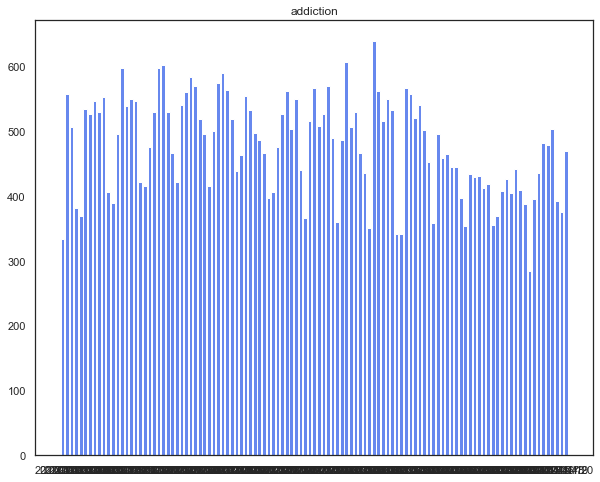

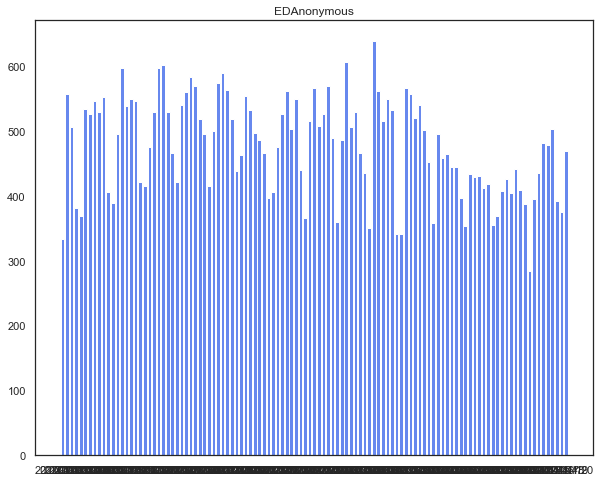

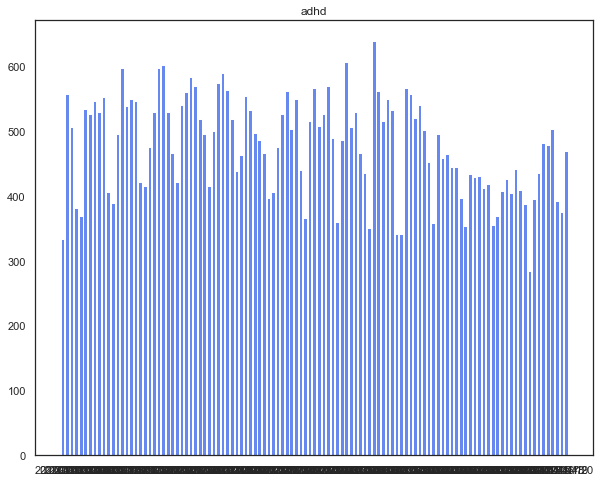

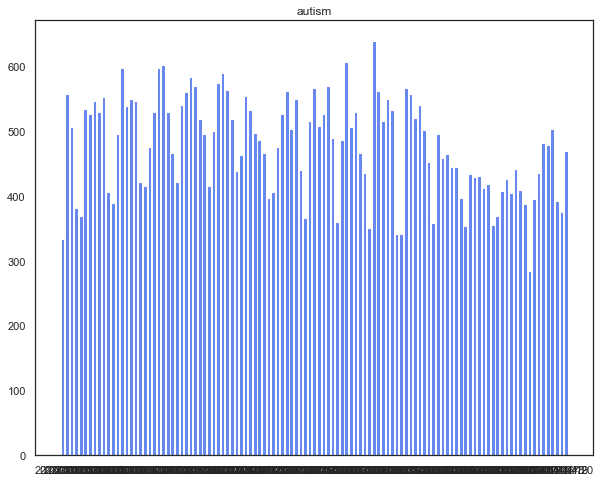

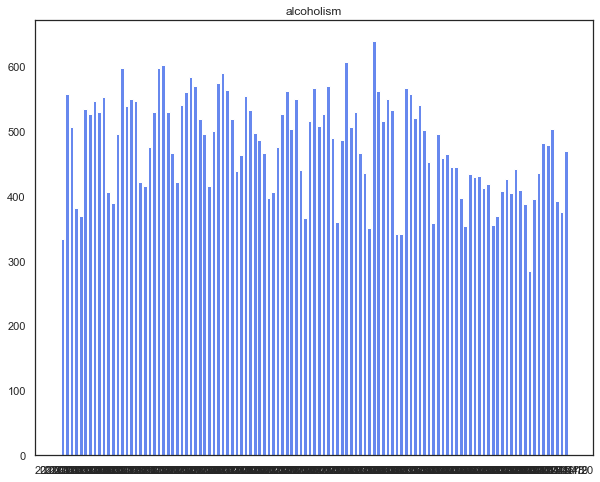

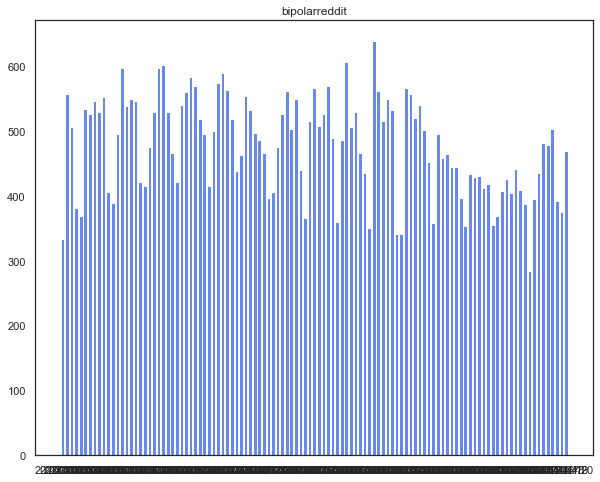

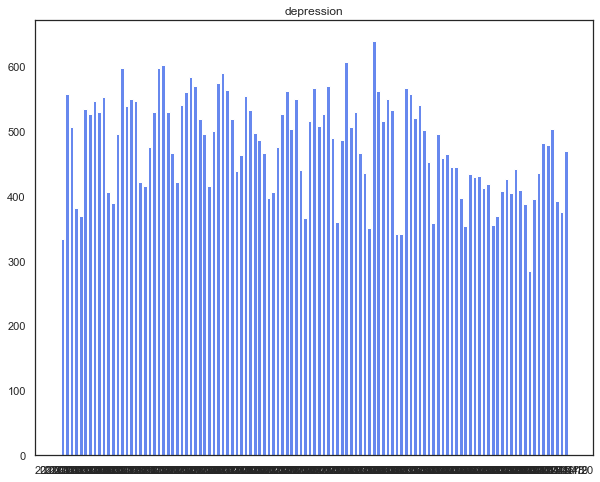

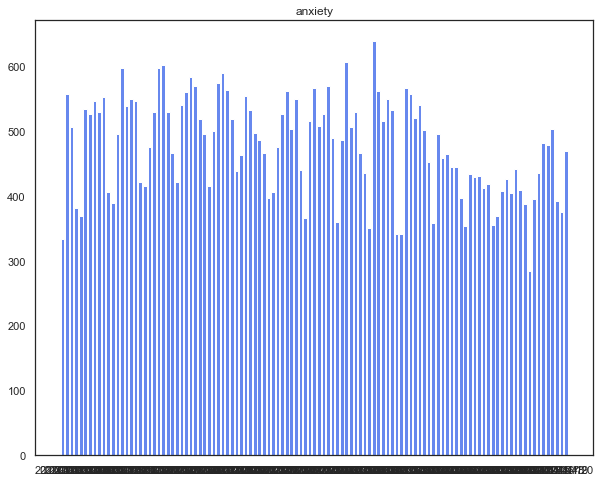

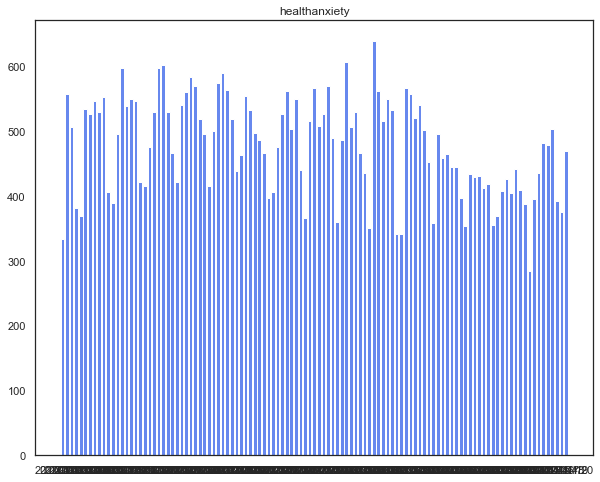

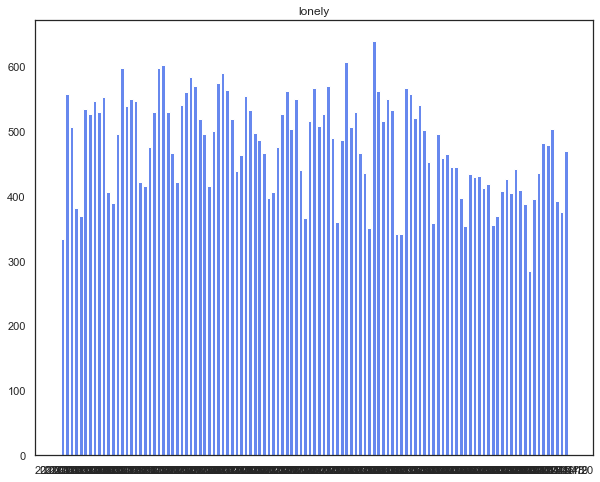

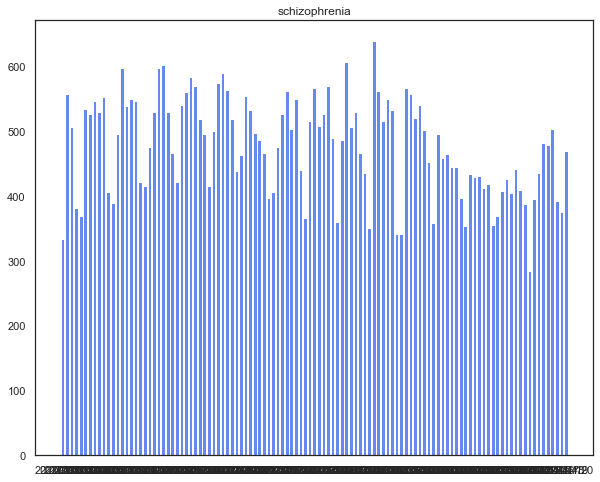

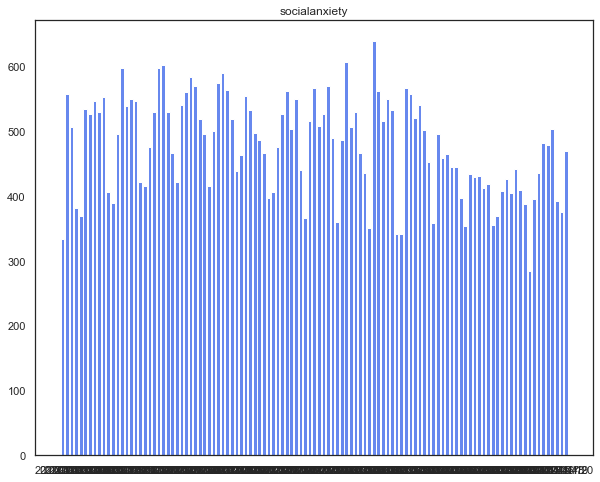

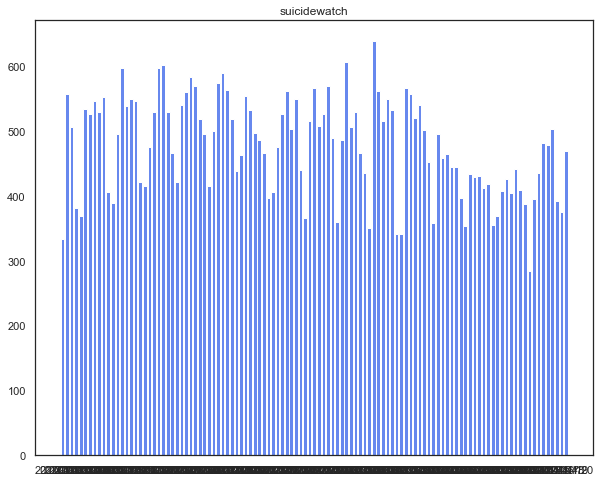

In [0]:
for d,sr in zip(days, subreddits_mental_health):
    counter = Counter(d)
    plt.figure()
    plt.title(sr)
    plt.bar(counter.keys(),height=counter.values())
    plt.show()



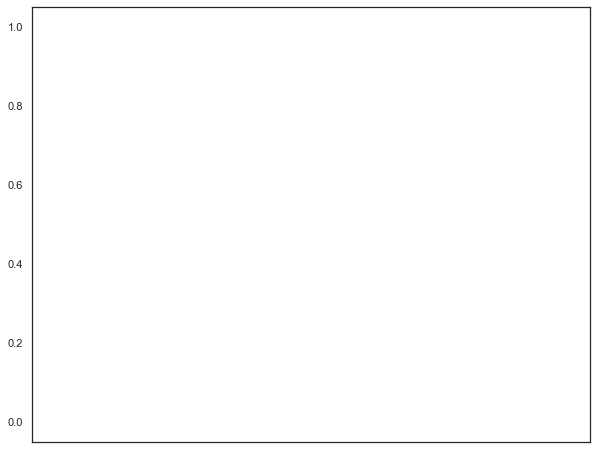

In [0]:
output_dir = './../../datum/reddit/input/'

In [0]:
df = pd.read_csv(output_dir+'features_depression_0.csv')
df.shape

(20980, 14)

In [0]:
# Search reddit
# Search unix code https://www.unixtimestamp.com/index.php
# Timeline: https://www.nytimes.com/article/coronavirus-timeline.html


In [0]:
# Anxiety corona virus
# JAN. 20 Other countries, including the United States, confirmed cases.
"I know this may sound silly, but I\u2019m scared of the coronavirus. A lot of people are saying it\u2019s not a big deal and that I\u2019ll be safe as long as I\u2019m healthy. I know all of this but I\u2019m more scared of the fact that this will turn into a pandemic."

# Other days:
# JAN. 30 The W.H.O. declared a global health emergency
# The World Health Organization on Feb. 11 proposed an official name for the disease the virus coronavirus causes: Covid-19
# Feb 23 Italy sees major surge in coronavirus cases and officials lock down towns.
subreddit = 'healthanxiety'
date_start = '2020/03/24'
date_end = '2020/03/30'

start = date2timestamp(date_start)
end = date2timestamp(date_end)
size = 1000000000
url = 'https://api.pushshift.io/reddit/search/submission/?subreddit={}&sort=desc&sort_type=created_utc&after={}&before={}&size={}'.format(subreddit,start, end, size)
print(url)
# filename = 'scrape_reddit'
# filename = filename+'_{}_{}'.format(date_start.replace('/', ''), date_end.replace('/', ''))


# Comment so it won't download

# url2json(url, output_dir+filename)
# anxiety_covid = json2list(output_dir+filename+'.json')

NameError: name 'date2timestamp' is not defined

In [0]:
timestamp2date(1579395379)

NameError: name 'timestamp2date' is not defined

In [0]:
def scrape_reddit(output_dir, subreddit, timeframe, date_start, date_end, size = 1000):
    '''
    size = {1,1000} #amount of posts
    '''
    start = date2timestamp(date_start)
    end = date2timestamp(date_end)
    url = 'https://api.pushshift.io/reddit/search/submission/?subreddit={}&sort=desc&sort_type=created_utc&after={}&before={}&size={}'.format(subreddit,start, end, size)
    filename = '{}_{}_{}_{}'.format(subreddit, timeframe, date_start.replace('/', ''), date_end.replace('/', ''))
    url2json(url, output_dir+filename)
    posts = json2list(output_dir+filename+'.json')
    posts_filtered = []
    for post in posts:
        post_filtered = {}
        for key in post.keys():
            post_filtered[key]=post.get(key)
        posts_filtered.append(post_filtered)
    # np.savez_compressed(input_dir+filename+'.npz',posts_filtered)
#     os.remove(output_dir+filename+'.json')
    return filename
        


In [0]:
date2timestamp(date_start)

NameError: name 'date2timestamp' is not defined

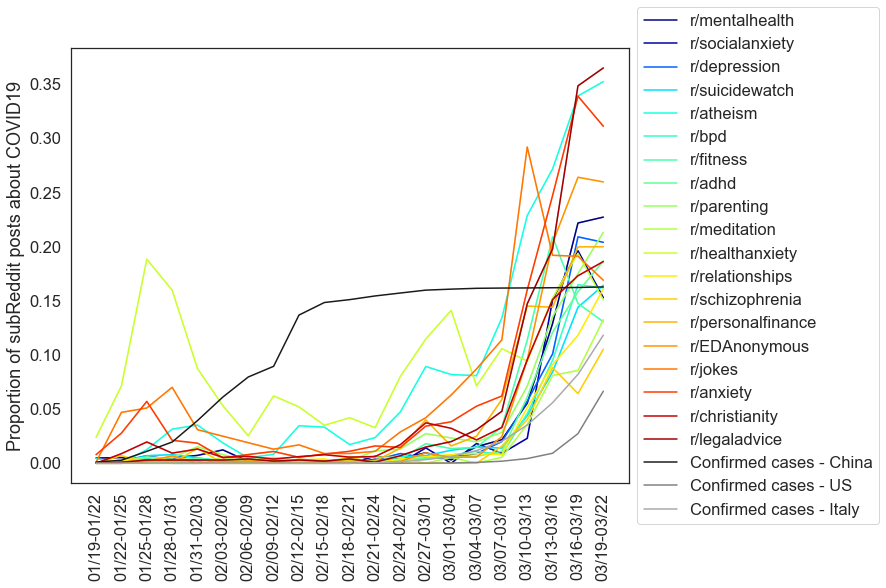

In [0]:
# subredditsx = ['anxiety', 'healthanxiety']
plot_across_time(subreddits,y_col = 'covid_boolean', y_col_div_by = 'total_posts',
                  ylabel='Proportion of subReddit posts about COVID19',filter_small = True, small_value = 150, 
                  plot_raw = True,  plot_line = False, alpha = 0.3, plot_covid_curves = True, zscore = False)



In [0]:
### Hypochondriac symptoms predict overall concern 1.5 months before. 
### All of Reddit converges on the same topic

In [0]:
'''
# Early:
01/19: {'created_utc': 1579618862, 'num_comments': 7, 'title': 'The breaking news stories about the coronavirus is making me really nervous and I’m not sure what to do?', 'selftext': 'I’ve been seeing a lot of news stories today about an incurable, lethal disease originating in China spreading to other countries. I know the media often over exaggerates things like this, but WHO is debating whether or not to declare this an international emergency. Nothing triggers my anxiety worse than things like this, if anyone has any advice on how to cope/can inform me on it I would really appreciate it!', 'score': 1},
01/19: {'created_utc': 1579543321, 'num_comments': 1, 'title': 'Wuhan Virus anxiety', 'selftext': "Right off the bat, i'm not chinese or live anywhere in the eastern part of the globe. But i am a massive hypochondriac and terrified of a global outbreak.  \n\n\nThis morning, i saw an article showing a video of airline passengers being screened by medical personal in hazmat suits. With the article spewing the whole sensationalized clickbait crap about an apocalyptic global epidemic.  \n\n\nAnd after seeing it i quickly spiraled into stress and anxiety. Even though i was able to avoid a full on panic attack, this article bothered me to the point that ll i've been thinking about is an outbreak for the rest of the day just by reading a news article for a few minutes.  \n\n\nI hope everybody in the east can stay safe and healthy, the worst i've had today is nearly having a panic attack. Can't imagine how worrying it is over there.", 'score': 1},
01/25: {'created_utc': 1580175419, 'num_comments': 3, 'title': 'so so so scared', 'selftext': 'this corona virus has me absolutely terrified. i know there\'s all these "low mortality" things, but i read to far into the conspiracies and the videos of chinese hospitals and doctors crying for help. \n\nive washed and sanitized my hands to the point they\'re cracked and bleeding. i won\'t leave the house anymore unless its 100% necessary.and even when i do i don\'t touch ANYTHING\n\nim so scared, breaking down crying, i can\'t even eat anymore. nothing the news or cdc says can calm me down because i am fully convinced china is lying and that this could even be a bioweapon. i heard it\'s mutated already and 300,000-1,000,000 people fled china possibly infected. i feel doomed'}



# Suicidality
03/16:        {'created_utc': 1584584727, 'num_comments': 0, 'title': 'I feel like a scared child but I have no parents to run to for safety', 'selftext': "I'm far from being actually alone, I don't even live alone, yet right now with the virus, the economic status, and the high stress everyone is feeling is making me feel like my bones are trying to crawl out of my flesh. I want it to stop, I want to scream and cry, I want to hide and honestly just fucking die so I don't have to live with any of these feelings anymore. I work minimum wage, I'm saving for the house I'm renting in May, but if I lose my job or can't work because of Covid-19 I am absolutely fucked. I am terrified and I feel pinned down by this overwhelming feeling it's all going to get so so much worse...Part of me wishes the world would just end. No worried then. No stress. I'm dreading my state saying we must stay home because my father is bipolar and refuses to go to therapy or get medication so I don't feel safe outside of my room and most of my social interactions outside of work come in arguments with him because he can never be wrong. He has to be right. I wish it would all just freeze or disappear.", 'score': 1},
# Works at hospital
03/16:        {'created_utc': 1584581971, 'num_comments': 0, 'title': 'Feeling overwhelmed about corona and working at the hospital', 'selftext': "I live in New York and work in a hospital. We were short on supplies even before the virus really became a thing here. We don't have masks to give patients. We are not allowed to wear masks ourself. We have been mandated to work and even been told to continue coming to work even if we have had contact with a confirmed positive. We just have to take our temperature daily &amp; we are only to wear a mask if we have active respiratory symptoms.\n\nI have constant shortness of breath and chest pains and pressure due to anxiety which has me constantly stressed. My throat is super dry and idk why. Dry throat and stress leaves you more susceptible to infection in addition to working in a war zone with no protection daily.\n\nI feel so anxious and overwhelmed. I was finally getting my panic attacks sorta under control by going out mor and starting therapy. That's all on hold for the indefinite future. Im constantly afraid of having another panic attack or being in the position where I feel like I'm actually dying and unable to see a provider due to the system being overwhelmed.\n\nThe only positive thing I have going on right now is that its about to be spring and I can garden while social distancing.", 'score': 1},
# Buying guns
03/16:        {'created_utc': 1584581413, 'num_comments': 24, 'title': 'Are we going to all die and go into an apocalypse? The media is starting to freak me out because of the Corona Virus', 'selftext': "I keep on seeing the Corona Virus everywhere now I hear people are buying guns then people are talking about Germany and how bad it is there. I thought that America was handling it very well. And we are on top of it? I'm freaking out. Am I overthinking between all the youtube posts I'm buggin.", 'score': 0},

03/16:        {'created_utc': 1584574890, 'num_comments': 1, 'title': 'My mom is driving herself crazy because of the COVID-19', 'selftext': 'My mom never have suffer from anxiety or other mental illness like OCD, etc. \nSince the COVID-19, we steam and sanitize our house all the day with the steamer machine, we use other product like Clorox or Javex, if she touches something in the house she wash her hand, I suffer from anxiety and it doesn’t help at all! I feel stress will kill our brain before the COVID-19, I’m tired, really tired, I want just this stupid virus to end and to go out. All we do is talking about this virus, the media is not helping at all... my head is gonna explode.', 'score': 3},
# GAD + Isolation  
      {'created_utc': 1584570369, 'num_comments': 0, 'title': 'Being single and living alone is absolutely brutal right now.', 'selftext': 'I live with generalized anxiety disorder and already have major anxiety regarding my health. Had the flu end of January pretty bad and then hives post flu- I’m miserable and was finally getting back on track and then this.\n\n\nI am terrified. Just being alone all day. And can’t see my parents or friends. Or brother. I have been so anxious through all of this for many reasons. \n\nfinally got the work from home okay on Monday but now being told by higher ups where I work (a health science college at a major uni) that someone needs to be in my office during the day, though it’s not essential. I hate the idea of going to my office which is connected to the main hospital in my city.\n\nAnyway. I really could use some people to talk to as I don’t have that many friends and that’s what I need now. I need some more connections and chances to get to other people and distract from the virus.\n\nThanks', 'score': 0},

'''

'\n# Early:\n01/19: {\'created_utc\': 1579618862, \'num_comments\': 7, \'title\': \'The breaking news stories about the coronavirus is making me really nervous and I’m not sure what to do?\', \'selftext\': \'I’ve been seeing a lot of news stories today about an incurable, lethal disease originating in China spreading to other countries. I know the media often over exaggerates things like this, but WHO is debating whether or not to declare this an international emergency. Nothing triggers my anxiety worse than things like this, if anyone has any advice on how to cope/can inform me on it I would really appreciate it!\', \'score\': 1},\n01/19: {\'created_utc\': 1579543321, \'num_comments\': 1, \'title\': \'Wuhan Virus anxiety\', \'selftext\': "Right off the bat, i\'m not chinese or live anywhere in the eastern part of the globe. But i am a massive hypochondriac and terrified of a global outbreak.  \n\n\nThis morning, i saw an article showing a video of airline passengers being screened by

In [0]:
subreddits2 = ['relationships','mindfulness', 'healthanxiety', 'anxiety', 'suicidewatch', 'depression', 'ptsd', 'adhd', 
              'bpd', 'paranoia', 'socialanxiety', 'schizophrenia', 'bipolarreddit', 'alcoholism', 'addiction',]







### Social anxiety: less posts, more words on average per post

In [0]:


plot_across_time('depression', y_col = 'sent_pos', y_col_div_by = False, zscore = False, 
                 ylabel='Positive sentiment',
                 small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.5, plot_covid_curves = False)

NameError: name 'output_dir' is not defined

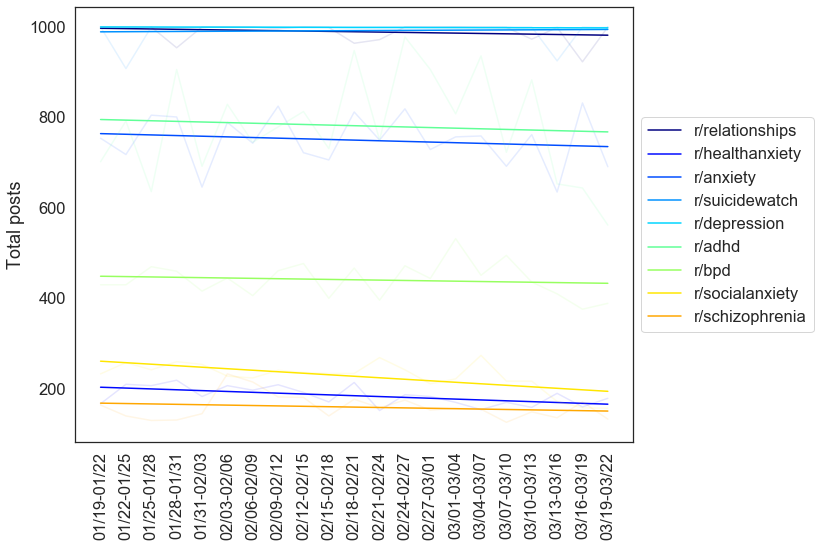

In [0]:
plot_across_time(subreddits2, y_col = 'total_posts', y_col_div_by = False, zscore = False, 
                 ylabel='Total posts',
                 small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.1, plot_covid_curves = False)

In [0]:
plot_across_time(subreddits2, y_col = 'total_posts', y_col_div_by = False, zscore = True, 
                 ylabel='Total posts',
                 small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.1, plot_covid_curves = False)


In [0]:
plot_across_time(subreddits2, y_col = 'all_words', y_col_div_by = 'total_posts', 
                 ylabel='Average words per post',
                 small_value = 150, plot_raw = True, zscore = True,
                     plot_line = True, alpha = 0.3, plot_covid_curves = False)

# Sentiment analysis: social anxiety getting less negative!

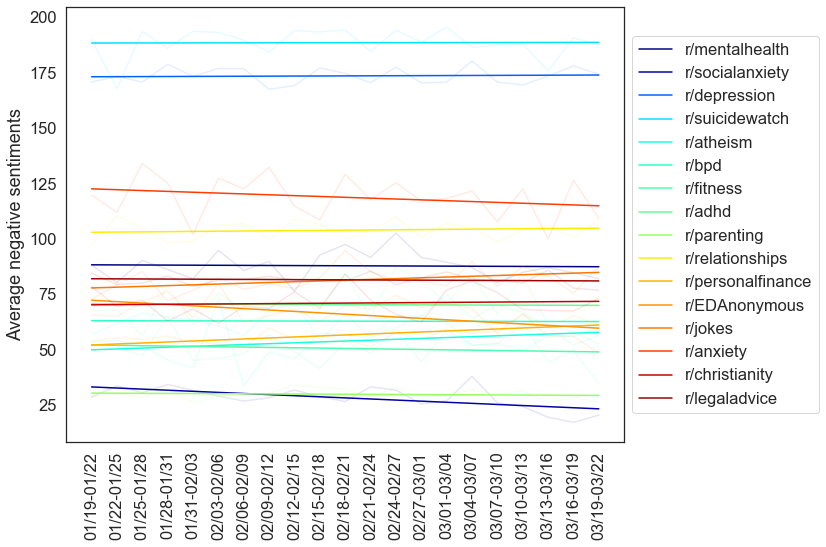

In [0]:
plot_across_time(subreddits, y_col = 'sent_neg', y_col_div_by = False, 
                 ylabel='Average negative sentiments',zscore = False,
                 filter_small = True, small_value = 200, plot_raw = True, 
                     plot_line = True, alpha = 0.1, plot_covid_curves = False)


In [0]:

# input y variable across time



In [0]:
subreddit = 'socialanxiety'
y_col = 'sent_neg'
df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))

# Load data
xs = list(set(df_subreddit.date.values))
try: xs.remove(np.nan)
except: pass
xs.sort()
ys = []
cs = []
for day in xs:
    df_subreddit_day = df_subreddit[df_subreddit.date == day]
    y = df_subreddit_day[y_col].values
    ys.append(y)
    median_value = int(np.median(y))
    median_max = np.percentile(y,90)
    color = median_max*10**2
    color = np.max(y)*10**2
    cs.append('hsl({}%,50%,50%)'.format(color))


# plot
fig = go.Figure(data=[go.Box(
    y=ys[i],
    marker_color=cs[i],
    name = xs[i],
    ) for i in range(len(xs))])

# format the layout
fig.layout.update(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=True,   ticktext = xs),
    yaxis=dict(zeroline=False, gridcolor='white'),
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
    showlegend=False,
    title=y_col+' as COVID-19 grows'
)

fig.show()

In [0]:
subreddit = 'socialanxiety'
df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
fig = px.scatter(df_subreddit, x="date", y="sent_neg", color="suicide_bool",hover_name='posts',
                 title=subreddit)

fig.show()

### Suicidality

In [0]:
subreddit = 'suicidewatch'
df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
fig = px.scatter(df_subreddit, x="date", y="sent_neg", color="sent_neg",hover_name='posts',
                 title="Numeric 'size' values mean continous color")

fig.show()

In [0]:
subreddit = 'suicidewatch'
df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
fig = px.scatter(df_subreddit, x="date", y="sent_neg", color="covid_boolean",hover_name='posts',
                 title=subreddit+' with COVID-19 related posts in yellow')

fig.show()

In [0]:
subreddit = 'socialanxiety'
df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
fig = px.scatter(df_subreddit, x="date", y="sent_neg", color="suicide_bool",hover_name='posts',
                 title=subreddit+' with suicidal related posts in yellow')

fig.show()




In [0]:
# The fact that it may be affecting ED more or certain disorders more could be useful
# How personal finance may be connected to mental could be studied: If personal finance become more similar to some disorder (tfidf))
# Target at risk people who post regularly and stopped posting? 



# TFIDF

In [0]:
# reload(extract_features)

In [0]:
# Create a corpus to build the matrix
posts_all = []
for sr in subreddits2:
    df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(sr))
    posts = df_subreddit.posts.values
    posts_all.append(posts)
    

corpus = [n for i in posts_all for n in i]
# remove nan
corpus = [n for n in corpus if isinstance(n,str)]

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1,3), stop_words='english',
                        max_features=512, min_df=2, max_df=0.8)



# Build matrix
vectorizer.fit_transform(corpus)

In [0]:
# Comment so it won't run



In [0]:
feature_array = np.array(vectorizer.get_feature_names())
n = 15

split = 0.9



for sr in subreddits2:
    df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(sr))
    posts = df_subreddit.posts.values
    posts = [n for n in posts if isinstance(n,str)]
    split_i = int(len(posts)*split)
    posts_before = posts[:split_i]
    posts_after = posts[split_i:]
    posts2 = [posts_before, posts_after]
    posts_names = ['before', 'after']
    for i in range(2):
        response = vectorizer.transform(posts2[i])
        tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
        top_n = feature_array[tfidf_sorting][:n]
        print('\n====={}==={}'.format(sr, posts_names[i]))
        print(top_n)
    print('\n\n===============')

In [0]:
# # Alternative method
# def tfidf(X_train_sentences = posts, lower_case = True, ngram_range = (1,3), max_features=512, min_df=2, max_df=0.8, model = 'svm'):
#     sw = stopwords.words('english')
#     vectorizer = TfidfVectorizer(lowercase=lower_case, ngram_range=ngram_range, stop_words=sw,max_features=max_features, min_df=min_df, max_df=max_df)
#     train_vectors = vectorizer.fit_transform(X_train_sentences).toarray()
#     feature_names = vectorizer.get_feature_names()
#     feature_names = ['tfidf_'+n for n in feature_names]
#     return train_vectors, feature_names
    
# X_test_sentences = False
# vectors, feature_names = tfidf(X_train_sentences = posts_all_days, lower_case = True, ngram_range = (1,3), max_features=512, min_df=2, max_df=0.8, model = 'svm')
    